In [1]:
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from HexDetector import hex_radius_inner_to_outer
from analysis_functions import *

set_matplotlib_style()

In [2]:
# run_path = '/home/akallits/Documents/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/ParameterTrees/Run243-Pool4_treeParam.root'
run_path = '/home/akallits/Documents/PicoAnalysis/Saclay_Analysis/data/2022_October_h4/processedTrees/ParameterTrees/Run224-Pool2_treeParam.root'
# run_path = '/home/akallits/Documents/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/ParameterTrees/Run325-Pool3_treeParam.root'
# run_path = '/local/home/dn277127/Bureau/picosec/Run243-Pool4_treeParam.root'
# run_path = '/home/dylan/Desktop/picosec/Run243-Pool4_treeParam.root'
# run_path = '/data/akallits/Saclay_Analysis/data/data/2023_April_h4/processedTrees/ParameterTrees/Run243-Pool4_treeParam.root'

In [3]:
tree = get_tree(run_path, 'ParameterTree')

In [4]:
# event_start, event_end = 4416, None
min_ampl, max_ampl = -2, 2  # V
min_charge, max_charge = -0, 50.0  # fC
min_charge_tot, max_charge_tot = -0, 100.0  # fC
xy_range_min, xy_range_max = -100, 100  # mm
# mm_saturation_voltage = 0.78 #
# mm_saturation_voltage = 0.38 #
mm_saturation_voltage = 1.4 #
chi2_quality = 3


In [5]:
channels = ['C1', 'C2', 'C4']
global_vars = ['eventNo', 'chi2track']
channel_vars = ['hitX', 'hitY']
peak_param_channel_vars = ['ampl', 'dampl', 'charge', 'echarge', 'echargefit', 'echargefixed', 'totcharge', 'totchargefixed', 'risetime', 'tfit20','tfit20_nb', 'tnaive20', 'sigmoidR[4]']

branches = []
for channel in channels:
    for channel_var in channel_vars:
        branches.append(f'{channel_var}_{channel}')
    for var in peak_param_channel_vars:
        branches.append(f'peakparam_{channel}/peakparam_{channel}.{var}')
for var in global_vars:
    branches.append(var)
df = get_df_branches(tree, branches)


# if event_start is not None:
#     df = df[df['eventNo'] >= event_start]
# if event_end is not None:
#     df = df[df['eventNo'] <= event_end]

<Report start=0 stop=34367 source='/home/akallits/Documents/PicoAnalysis/Saclay_Analysis/data/2022_October_h4/processedTrees/ParameterTrees/Run224-Pool2_treeParam.root:/ParameterTree;1'>


Start processing: 34367 events
0.00016310487990267575 46.9718132019043
Number of tracks above 3: 2360
Number of tracks 32925
Original number of events with tracks: 32223
After chi2 cut number of events with tracks: 30402
0.00016310487990267575 2.9984560012817383


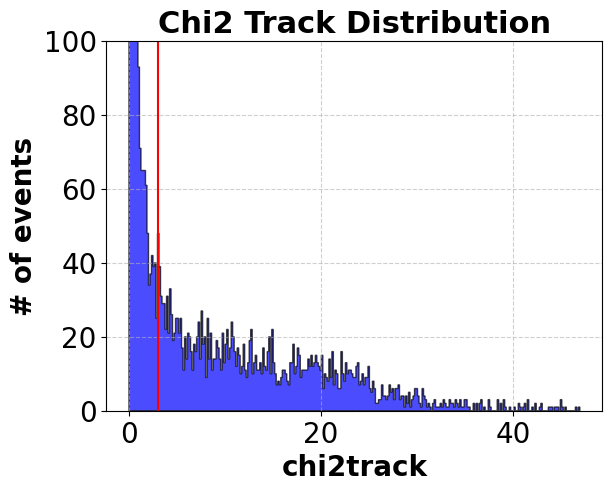

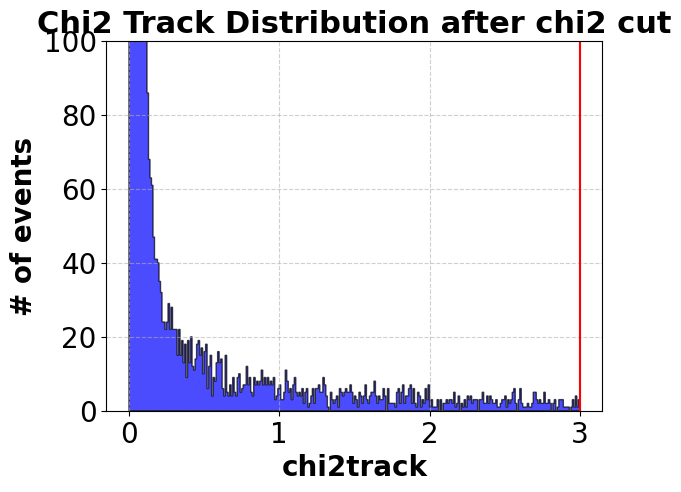

In [6]:
print(f'Start processing: {df["eventNo"].shape[0]} events')
make_chi2_cut_tracks(df, channels, chi2_quality, plot=True)

In [7]:
for channel in channels:
    get_single_peak(df, channel)
    
median_x, median_y = get_center_all_tracks(df, 'C1')
get_closest_track_indices(df, 'C1', (median_x, median_y))


In [8]:
for channel in channels:
    for xy in ['X', 'Y']:
        col_name = f'hit{xy}_{channel}'
        df[col_name] = df.apply(lambda row: row[col_name][int(row['closest_hit_index'])] if isinstance(row[col_name], list) and ~np.isnan(row['closest_hit_index']) else np.nan, axis=1)


In [9]:
event_start_number = get_run_event_start(df)
print(event_start_number)
# event_start, event_end = 4416, None
event_start, event_end = event_start_number, None

if event_start is not None:
    df = df[df['eventNo'] >= event_start]
if event_end is not None:
    df = df[df['eventNo'] <= event_end]

None


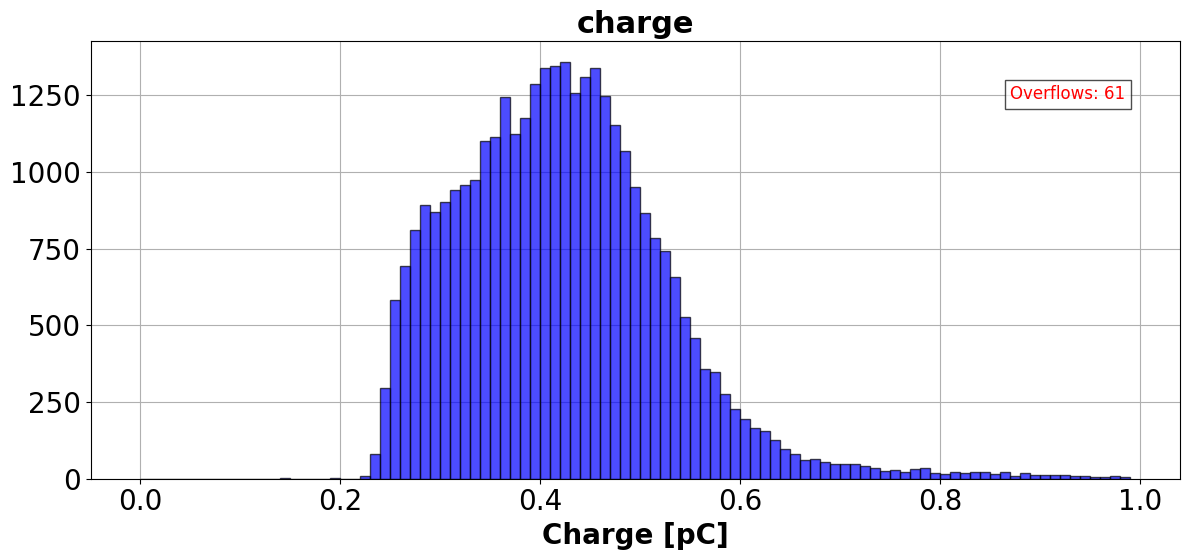

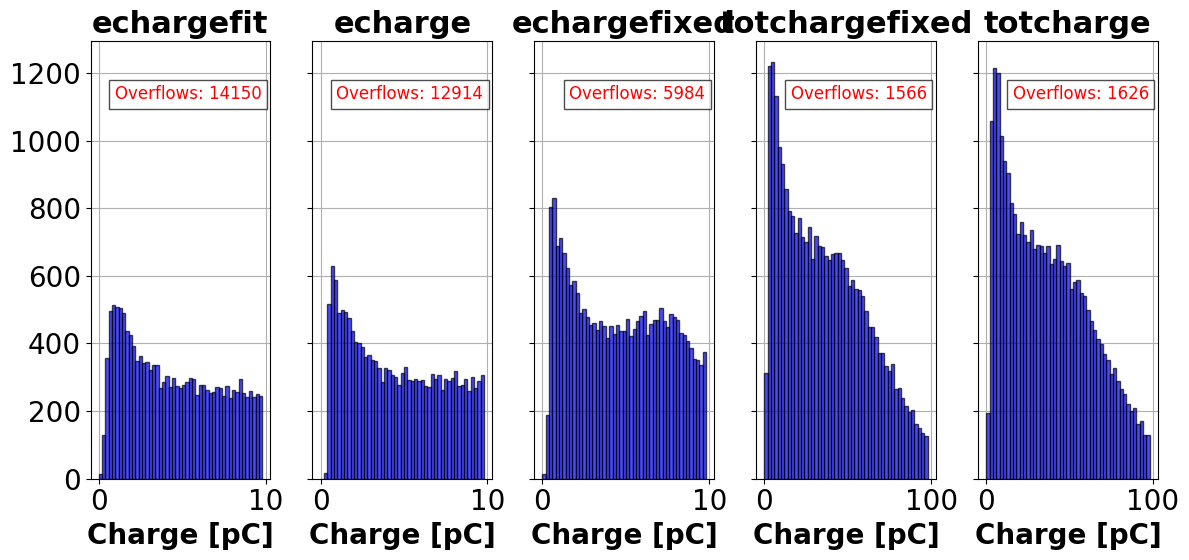

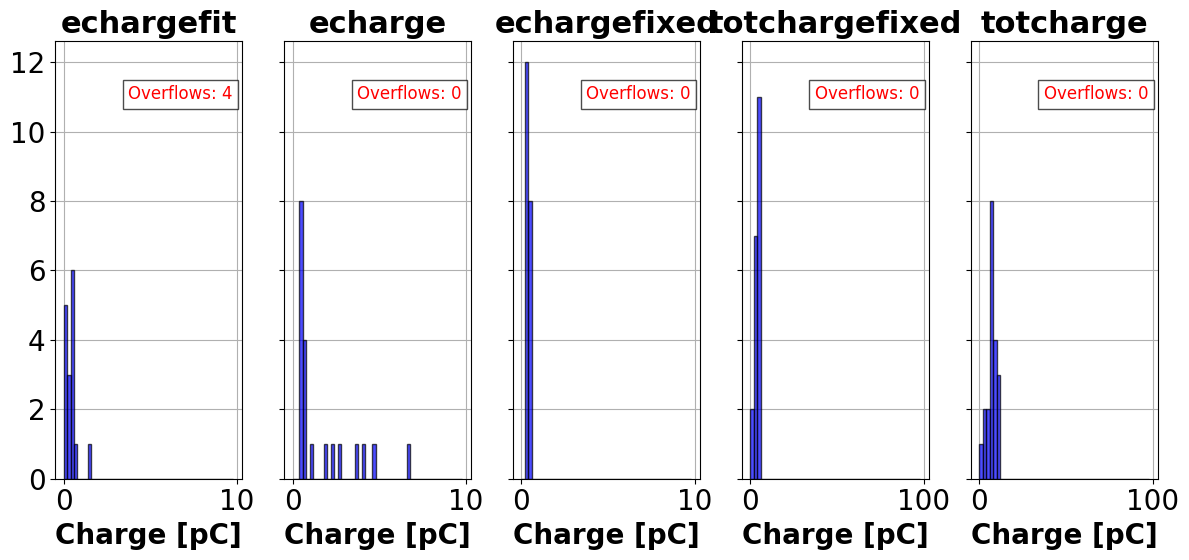

In [10]:
# Loop over channels
mcp_bins = np.arange(0, 1.0, 0.01)
ebins = np.arange(0, 10, 0.2)
totbins = np.arange(0, 100, 2)

for channel in ['C1', 'C2', 'C4']:
    if channel == 'C1':
        charge_types = ["charge"]
    else:
        charge_types = ["echargefit", "echarge", "echargefixed", "totchargefixed", "totcharge"]

    num_charges = len(charge_types)

    fig, axes = plt.subplots(1, num_charges, figsize=(12,6), sharey=True)

    # Ensure axes is always iterable (wrap in list if only one subplot)
    if num_charges == 1:
        axes = [axes]

    # fig.suptitle(f"Histograms of Charges for {channel}", fontsize=14)

    for i, charge_type in enumerate(charge_types):
        key = f'peakparam_{channel}/peakparam_{channel}.{charge_type}'
        charge_data = df[key]

        if "totcharge" in charge_type:
            filtered_data = charge_data[(charge_data > min_charge_tot) & (charge_data < max_charge_tot)]
            binning = totbins

        else:
            filtered_data = charge_data[(charge_data > min_charge) & (charge_data < max_charge)]
            binning = ebins
            if channel == 'C1':
                binning = mcp_bins

        n_overflows = np.sum(charge_data > binning[-1])
        axes[i].hist(filtered_data, bins=binning, alpha=0.7, color='blue', edgecolor='black', zorder=2)
        axes[i].set_title(charge_type)
        axes[i].set_xlabel('Charge [pC]')
        axes[i].grid(True, zorder=0)
        # Add overflow text
        axes[i].text(
            0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
            f'Overflows: {n_overflows}',
            transform=axes[i].transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
            fontsize=12, color='red', ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Add a background box
        )
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout
plt.savefig(f'charge_histograms_{channel}.pdf', dpi=300)
plt.savefig(f'charge_histograms_{channel}.png', dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


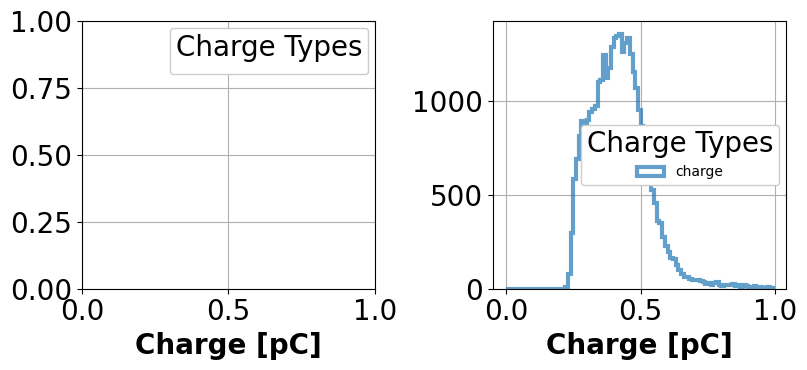

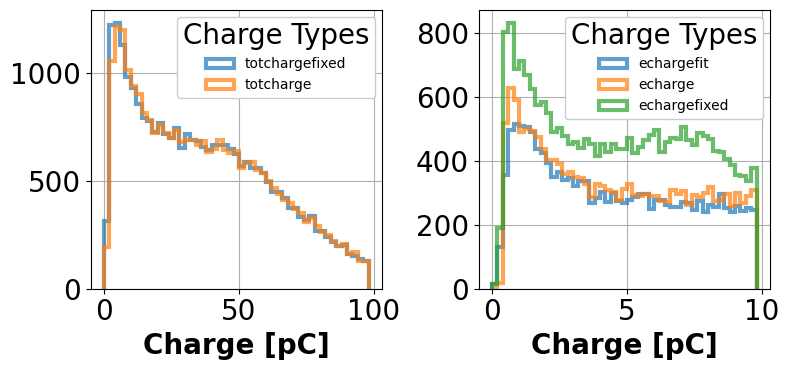

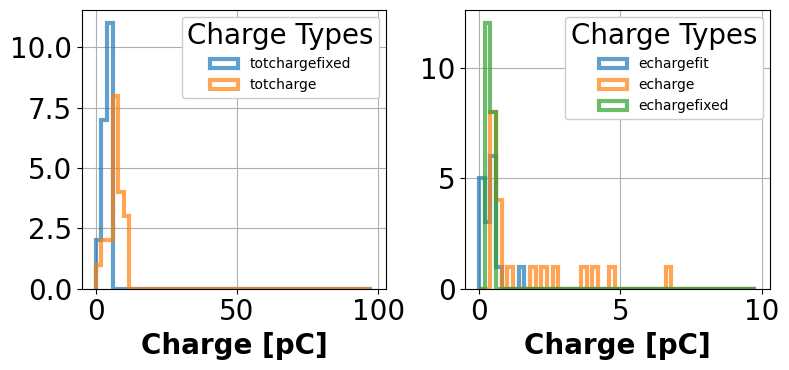

In [11]:
channel_charge_types = {
    'C1': ["charge"],
    'C2': ["echargefit", "echarge", "echargefixed", "totchargefixed", "totcharge"],
    'C4': ["echargefit", "echarge", "echargefixed", "totchargefixed", "totcharge"]
}

# Loop through the channels you want to plot
for channel in ['C1', 'C2', 'C4']:
    charge_types = channel_charge_types[channel]  # Select charge types based on the channel

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))  # Create figure with 2 subplots (ncols=2)

    # Loop over each charge type for the current channel
    for charge_type in charge_types:
        key = f'peakparam_{channel}/peakparam_{channel}.{charge_type}'
        charge_data = df[key]

        # Apply filters based on the charge type (e.g., total charge vs. echarge)
        if "totcharge" in charge_type:
            filtered_data = charge_data[(charge_data > min_charge_tot) & (charge_data < max_charge_tot)]
            binning = totbins
            ax_num = 0  # First subplot (totcharge)
        else:
            filtered_data = charge_data[(charge_data > min_charge) & (charge_data < max_charge)]
            binning = ebins
            ax_num = 1  # Second subplot (echarge)
            if channel == 'C1':
                binning = mcp_bins  # Special binning for C1

        # Plot the histogram
        n, bins, _ = axs[ax_num].hist(filtered_data, bins=binning, alpha=0.7, label=charge_type,
                                      zorder=2, histtype='step', linewidth=3)

        # Optional: Adding labels on top of histogram lines (bins)
        for i in range(len(bins)-1):
            # Find the position to put the label (at the middle of each bin)
            bin_center = (bins[i] + bins[i+1]) / 2
            count = n[i]  # Get the count (height) of the histogram at this bin
            # axs[ax_num].text(bin_center, count, f'{int(count)}', ha='center', va='bottom', fontsize=8)

    # Customize the plots
    axs[0].set_xlabel('Charge [pC]')
    axs[0].grid(True)
    axs[1].set_xlabel('Charge [pC]')
    axs[1].grid(True)

    # Add legends to the subplots
    axs[0].legend(title="Charge Types")
    axs[1].legend(title="Charge Types")

    # Set title for the current channel
    # fig.suptitle(f"Histograms of Charges for {channel}", fontsize=14)

    # Adjust the layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show plot for the current channel
    plt.show()

In [12]:
time_col = 'tfit20_nb'
df['C4_time_diff'] = df[f'peakparam_C4/peakparam_C4.{time_col}'] - df[f'peakparam_C1/peakparam_C1.{time_col}']
df['C2_time_diff'] = df[f'peakparam_C2/peakparam_C2.{time_col}'] - df[f'peakparam_C1/peakparam_C1.{time_col}']

filters = {channel: {} for channel in channels}
for channel in channels:
    
    tot_charge_data = df[f'peakparam_{channel}/peakparam_{channel}.totcharge']
    filters[channel].update({'totcharge_cut': (tot_charge_data > min_charge_tot) & (tot_charge_data < max_charge_tot)})

    charge_data = df[f'peakparam_{channel}/peakparam_{channel}.charge']
    filters[channel].update({'charge_cut': (charge_data > min_charge_tot) & (charge_data < max_charge_tot)})

    ampl_data = df[f'peakparam_{channel}/peakparam_{channel}.ampl']
    filters[channel].update({'ampl_cut': (ampl_data > min_ampl) & (ampl_data < max_ampl)})

    dampl_data = df[f'peakparam_{channel}/peakparam_{channel}.dampl']
    filters[channel].update({'dampl_cut': (dampl_data > min_ampl) & (dampl_data < max_ampl)})
    filters[channel].update({'saturation_cut': dampl_data < mm_saturation_voltage})

    echarge_fit_data = df[f'peakparam_{channel}/peakparam_{channel}.echargefit']
    filters[channel].update({'echargefit_cut': (echarge_fit_data > min_charge) & (echarge_fit_data < max_charge)})

    x_data = df[f'hitX_{channel}']
    y_data = df[f'hitY_{channel}']
    
    xy_filter_cut = (x_data > xy_range_min) & (x_data < xy_range_max) & (y_data > xy_range_min) & (y_data < xy_range_max)
    filters[channel].update({'xy_cut': xy_filter_cut})
    
    
    
# print(filters)

# mm_basic_charge_cut = (0.2 < df['peakparam_C4/peakparam_C4.totcharge_filtered']) & (df['peakparam_C4/peakparam_C4.totcharge_filtered'] < 100)
# mcp_basic_charge_cut = (0 < df['peakparam_C1/peakparam_C1.charge_filtered']) & (df['peakparam_C1/peakparam_C1.charge_filtered'] < 2)
# good_mm_mcp_charge_events = mm_basic_charge_cut & mcp_basic_charge_cut

# Get filtered dataframes for each channel -- charge filter 
c1_charge_filtered_df = df[filters['C1']['charge_cut']] 
c2_charge_filtered_df = df[filters['C2']['totcharge_cut']]
c4_charge_filtered_df = df[filters['C4']['totcharge_cut']] 

#Get the tracks for the filtered dataframes
# c1_charge_filtered_df = df[filters['C1']['xy_cut']]

x_c1_filtered = c1_charge_filtered_df[f'hitX_C1']
y_c1_filtered = c1_charge_filtered_df[f'hitY_C1']
x_c4_filtered = c4_charge_filtered_df[f'hitX_C4']
y_c4_filtered = c4_charge_filtered_df[f'hitY_C4']

C1 Number of outliers: 0 of 34367
C1 Number after filter: 34367 of 34367
C1 channel: min = 0.1477918534104456, max = 1.941143734999601
C2 Number of outliers: 1490 of 29115
C2 Number after filter: 27625 of 29115
C2 channel: min = 0.4848050492041071, max = 99.99587371406047
C4 Number of outliers: 13 of 33
C4 Number after filter: 20 of 33
C4 channel: min = 1.6900442159069182, max = 11.397266348302951


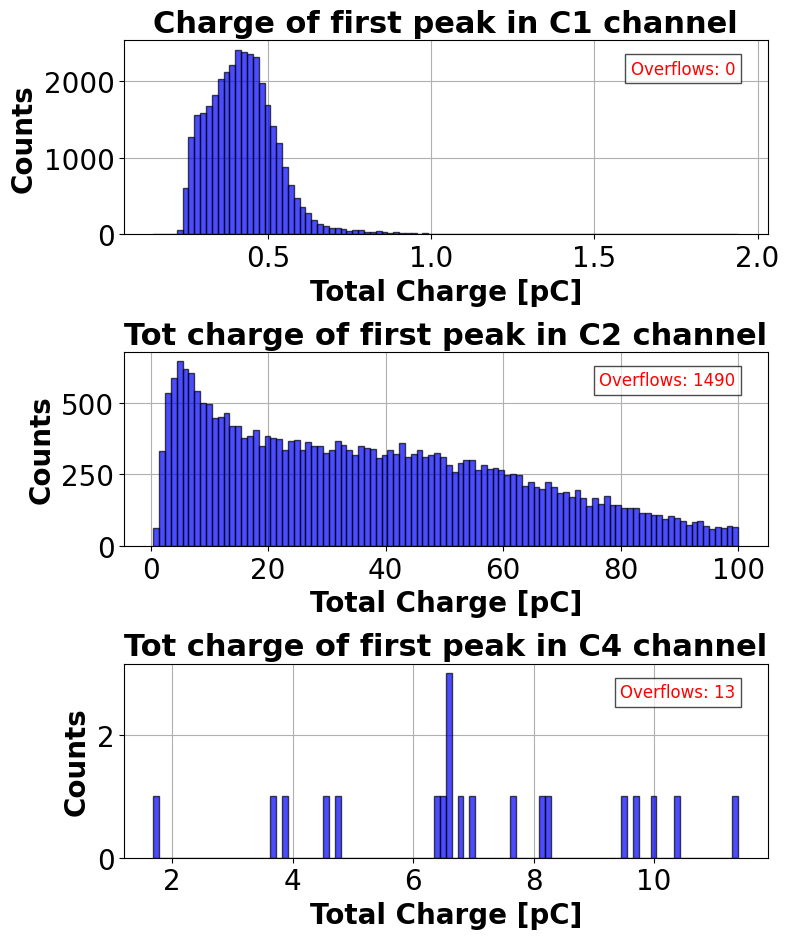

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))  # 3 rows, 1 column

for i, channel in enumerate(['C1', 'C2', 'C4']):
    # Get first charge or total charge based on the channel
    if channel == 'C1':
        first_charges_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.charge']
        df_filter = df[filters[channel]['charge_cut']]
        first_charges_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.charge']
    else:
        first_charges_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.totcharge']
        df_filter = df[filters[channel]['totcharge_cut']]
        first_charges_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.totcharge']

    # Convert to numpy arrays for filtering
    n_overflows = np.sum(first_charges_unfiltered < min_charge_tot) + np.sum(first_charges_unfiltered > max_charge_tot)  # Overflow count
    n_in_range = len(first_charges_filtered)
    n_total = n_in_range + n_overflows

    # Print outliers information
    print(f'{channel} Number of outliers: {n_overflows} of {n_total}')
    print(f'{channel} Number after filter: {len(first_charges_filtered)} of {n_total}')
    print(f'{channel} channel: min = {np.nanmin(first_charges_filtered)}, max = {np.nanmax(first_charges_filtered)}')

    # Plot each channel's charge histogram
    ax = axes[i]  # Use the appropriate axis in the grid
    ax.hist(first_charges_filtered, bins=100, alpha=0.7, color='blue', edgecolor='black', zorder=2)

    # Set title based on the channel
    if channel == 'C1':
        ax.set_title(f'Charge of first peak in {channel} channel')
    else:
        ax.set_title(f'Tot charge of first peak in {channel} channel')

    # Set labels
    ax.set_xlabel('Total Charge [pC]')
    ax.set_ylabel('Counts')

    # Add overflow text
    ax.text(
        0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
        f'Overflows: {n_overflows}',
        transform=ax.transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
        fontsize=12, color='red', ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Background box
    )

    ax.grid(True, zorder=0)

# Adjust layout to avoid overlap and ensure titles fit
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap

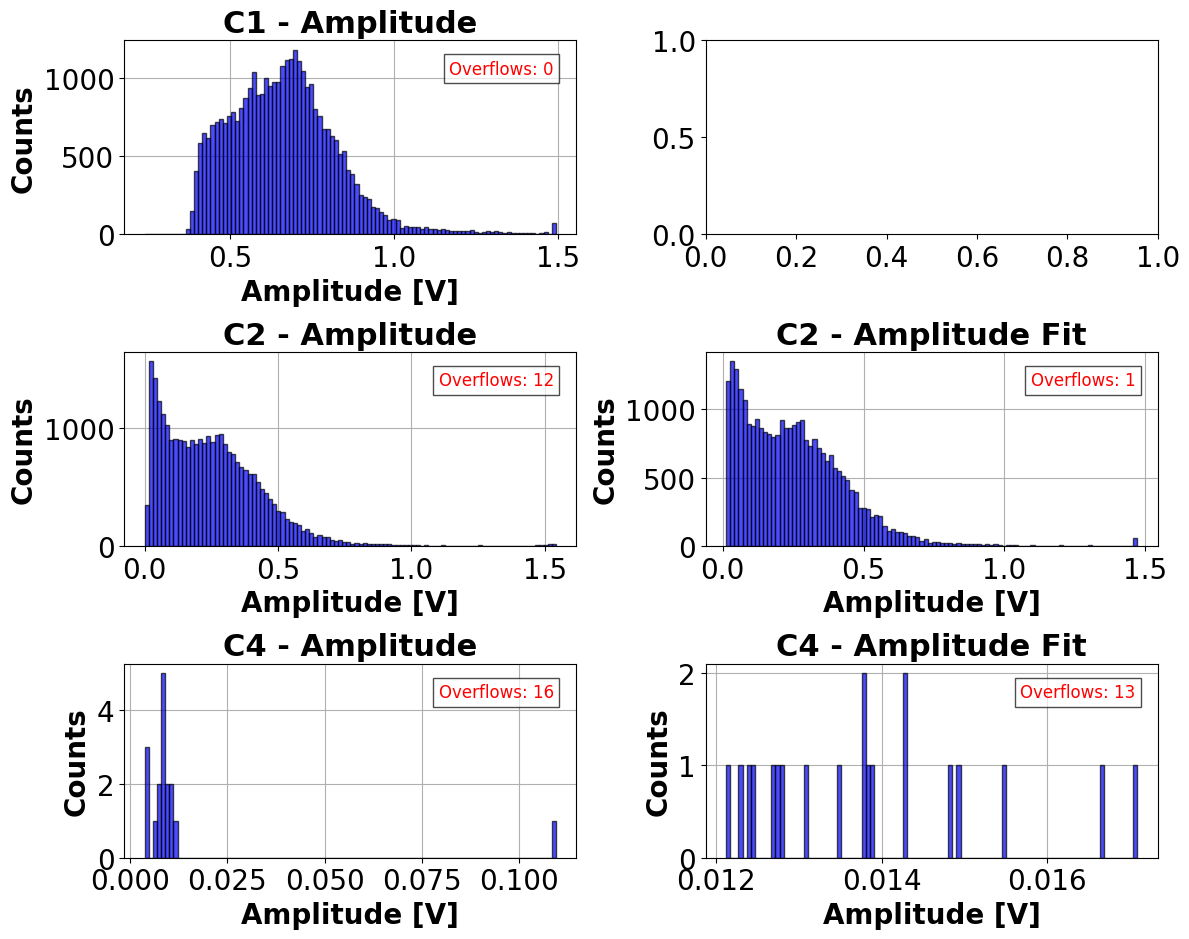

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))  # 3 rows, 2 columns

for i, channel in enumerate(['C1', 'C2', 'C4']):
    # First peak amplitude histogram
    first_ampls_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.ampl']
    df_filter = df[filters[channel]['ampl_cut']]
    first_ampls_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.ampl']

    n_overflows = np.sum(first_ampls_unfiltered < min_ampl) + np.sum(first_ampls_unfiltered > max_ampl)  # Overflow count
    n_in_range = len(first_ampls_filtered)
    n_total = n_in_range + n_overflows

    # Plot first_ampls_filtered histogram
    ax = axes[i, 0]  # Left column
    ax.hist(first_ampls_filtered, bins=100, alpha=0.7, color='blue', edgecolor='black', zorder=2)
    ax.set_title(f'{channel} - Amplitude')
    ax.set_xlabel('Amplitude [V]')
    ax.set_ylabel('Counts')
    ax.grid(True, zorder=0)

    # Add overflow text for first_ampls
    ax.text(
        0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
        f'Overflows: {n_overflows}',
        transform=ax.transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
        fontsize=12, color='red', ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Background box
    )

    # For C2 and C4, add the second amplitude (dampl) plot
    if channel in ['C2', 'C4']:
        first_dampls_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.dampl']
        df_filter = df[filters[channel]['dampl_cut']]
        first_dampls_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.dampl']

        n_overflows = np.sum(first_dampls_unfiltered < min_ampl) + np.sum(first_dampls_unfiltered > max_ampl)  # Overflow count
        n_in_range = len(first_dampls_filtered)
        n_total = n_in_range + n_overflows

        # Plot first_dampls_filtered histogram
        ax = axes[i, 1]  # Right column
        ax.hist(first_dampls_filtered, bins=100, alpha=0.7, color='blue', edgecolor='black', zorder=2)
        ax.set_title(f'{channel} - Amplitude Fit')
        ax.set_xlabel('Amplitude [V]')
        ax.set_ylabel('Counts')
        ax.grid(True, zorder=0)

        # Add overflow text for first_dampls
        ax.text(
            0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
            f'Overflows: {n_overflows}',
            transform=ax.transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
            fontsize=12, color='red', ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Background box
        )

# Adjust layout
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap
plt.savefig('amplitude_histograms.pdf', dpi=300)

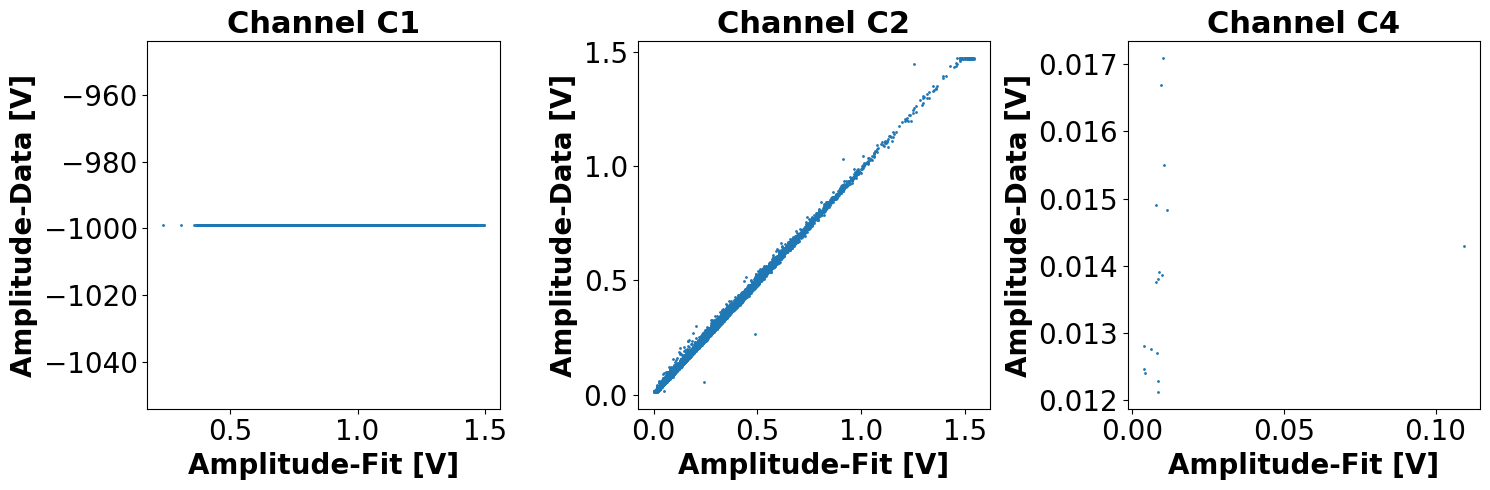

In [15]:
channels = filters.keys()  # Get all available channels
num_channels = len(channels)

fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(5*num_channels, 5))

if num_channels == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

for ax, ch in zip(axes, channels):
    df_filter = df[filters[ch]['ampl_cut']]
    ampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.ampl']
    dampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.dampl']

    ax.scatter(ampl_filtered, dampl_filtered, s=1)
    ax.set_title(f'Channel {ch}')
    ax.set_xlabel('Amplitude-Fit [V]')
    ax.set_ylabel('Amplitude-Data [V]')
# fig.text(0.5, 0.02, 'Amplitude-Fit [V]', ha='center', fontsize=12)
plt.tight_layout()

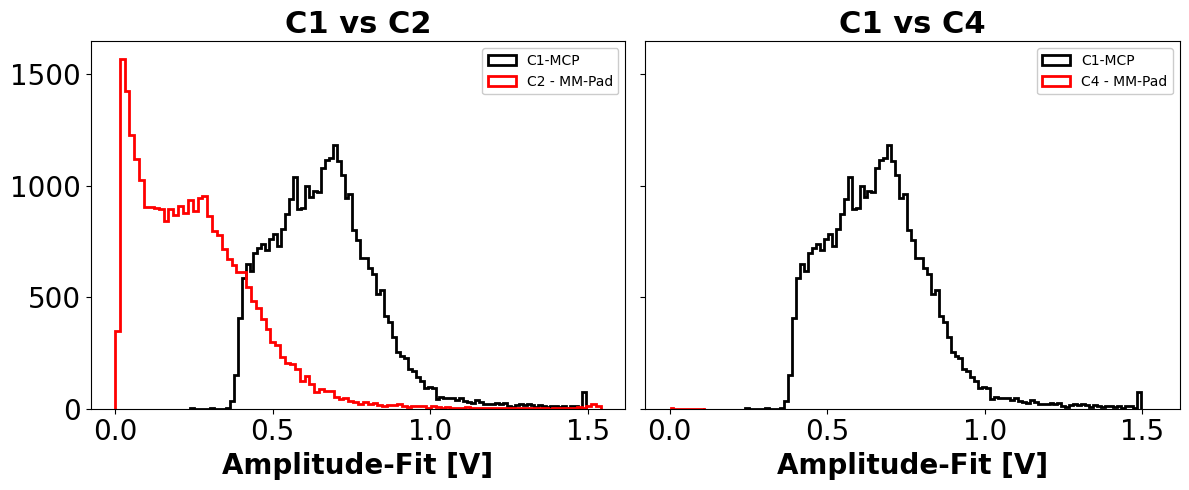

In [16]:
compare_ch_ampl = [ch for ch in filters.keys() if ch != 'C1']

num_plots = len(compare_ch_ampl)
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(6*num_plots, 5), sharex=True, sharey=True)

if num_plots == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

# Filter C1 data once (to avoid redundant computation)
df_filter_c1 = df[filters['C1']['ampl_cut']]
c1_ampl_filtered = df_filter_c1['peakparam_C1/peakparam_C1.ampl']

for ax, ch in zip(axes, compare_ch_ampl):
    # Apply filter for the other channel
    df_filter_ch = df[filters[ch]['ampl_cut']]
    ch_ampl_filtered = df_filter_ch[f'peakparam_{ch}/peakparam_{ch}.ampl']

    # Plot histograms
    ax.hist(c1_ampl_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    ax.hist(ch_ampl_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch} - MM-Pad')

    # Set title and legend
    ax.set_title(f'C1 vs {ch}')
    ax.set_xlabel('Amplitude-Fit [V]')
    ax.legend()

plt.tight_layout()

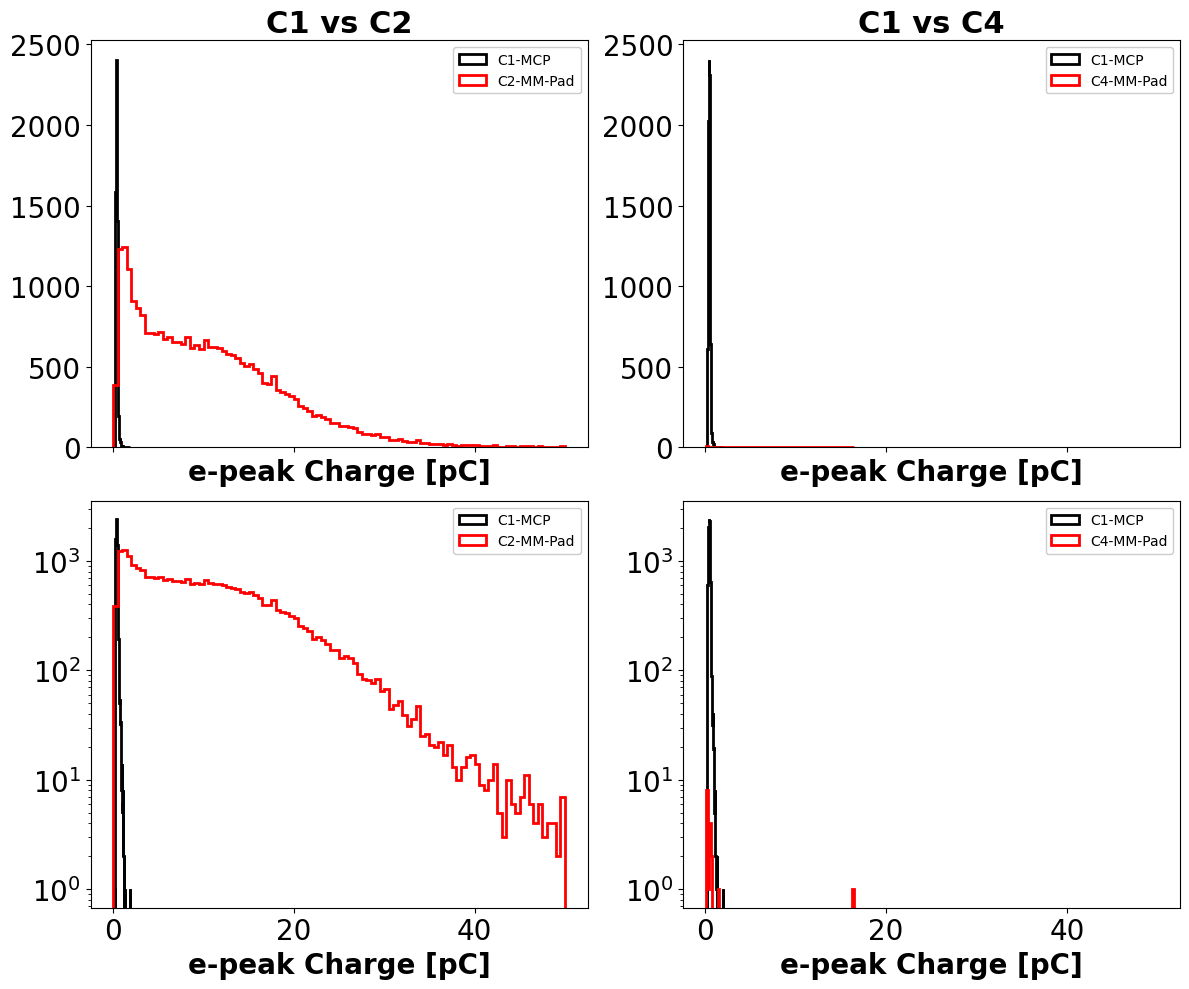

In [17]:
# Get all channels except C1
compare_ch_charge = [ch for ch in filters.keys() if ch != 'C1']

num_plots = len(compare_ch_charge)
fig, axes = plt.subplots(nrows=2, ncols=num_plots, figsize=(6*num_plots, 10), sharex=True, sharey=False)

if num_plots == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

# Filter C1 data once (to avoid redundant computation)
df_filter_c1 = df[filters['C1']['charge_cut']]
c1_ch_filtered = df_filter_c1['peakparam_C1/peakparam_C1.charge']

for col, ch in enumerate(compare_ch_charge):
    # Apply filter for the other channel
    df_filter_ch = df[filters[ch]['echargefit_cut']]
    ch_ech_filtered = df_filter_ch[f'peakparam_{ch}/peakparam_{ch}.echargefit']

    # Linear scale histogram (first row)
    axes[0, col].hist(c1_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[0, col].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[0, col].set_title(f'C1 vs {ch}')
    axes[0, col].set_xlabel('e-peak Charge [pC]')
    axes[0, col].legend()

    # Log scale histogram (second row)
    axes[1, col].hist(c1_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[1, col].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[1, col].set_yscale('log')  # Set log scale for y-axis
    axes[1, col].set_xlabel('e-peak Charge [pC]')
    axes[1, col].legend()

plt.tight_layout()

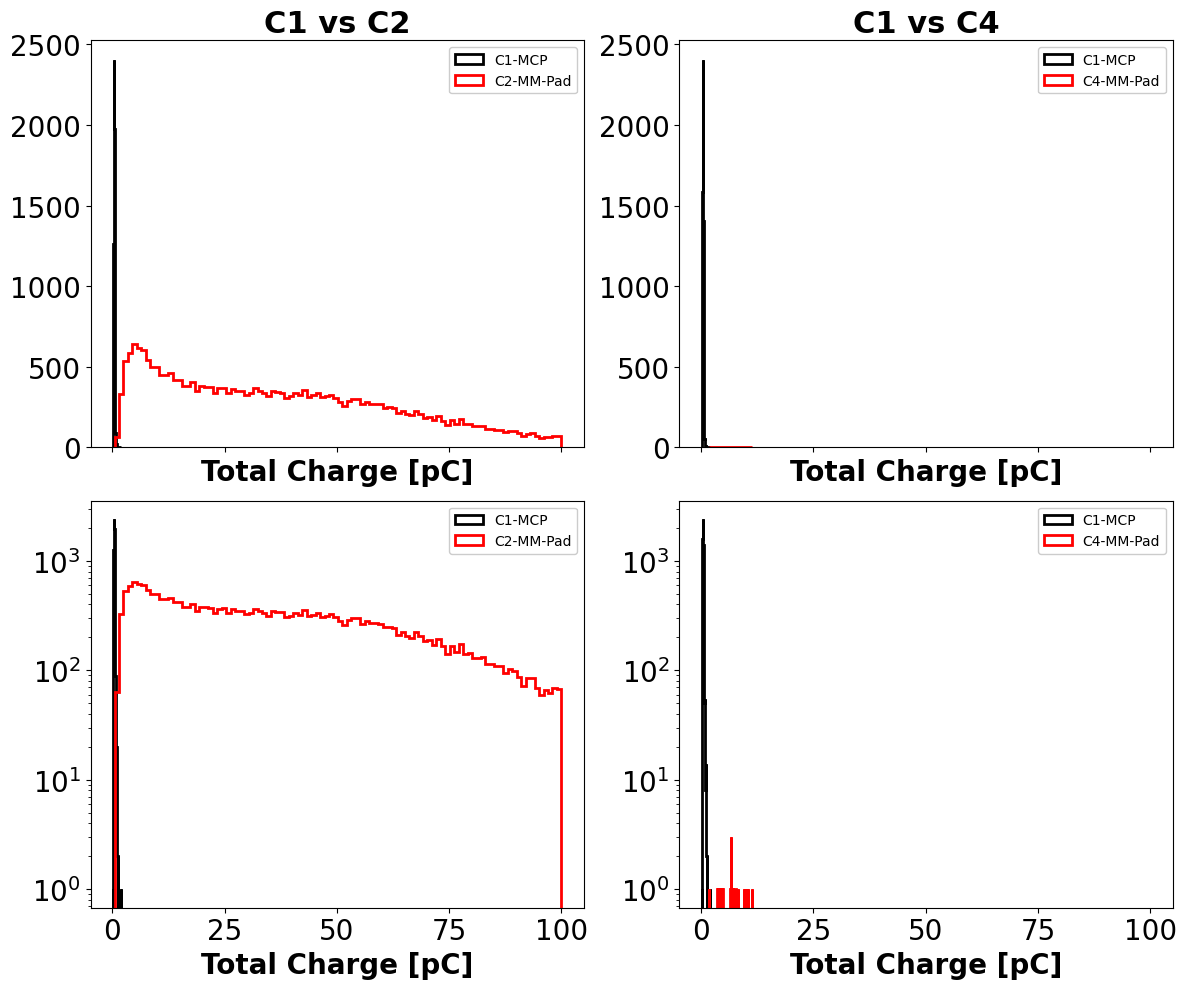

In [18]:
# Get all channels except C1
compare_ch_totcharge = [ch for ch in filters.keys() if ch != 'C1']

num_plots = len(compare_ch_totcharge)
fig, axes = plt.subplots(nrows=2, ncols=num_plots, figsize=(6*num_plots, 10), sharex=True, sharey=False)

if num_plots == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

# Filter C1 data once (to avoid redundant computation)
df_filter_c1 = df[filters['C1']['charge_cut']]
c1_ch_filtered = df_filter_c1['peakparam_C1/peakparam_C1.charge']

for col, ch in enumerate(compare_ch_totcharge):
    # Apply filter for the other channel
    df_filter_ch = df[filters[ch]['totcharge_cut']]
    ch_ech_filtered = df_filter_ch[f'peakparam_{ch}/peakparam_{ch}.totcharge']

    # Linear scale histogram (first row)
    axes[0, col].hist(c1_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[0, col].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[0, col].set_title(f'C1 vs {ch}')
    axes[0, col].set_xlabel('Total Charge [pC]')
    axes[0, col].legend()

    # Log scale histogram (second row)
    axes[1, col].hist(c1_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[1, col].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[1, col].set_yscale('log')  # Set log scale for y-axis
    axes[1, col].set_xlabel('Total Charge [pC]')
    axes[1, col].legend()

plt.tight_layout()

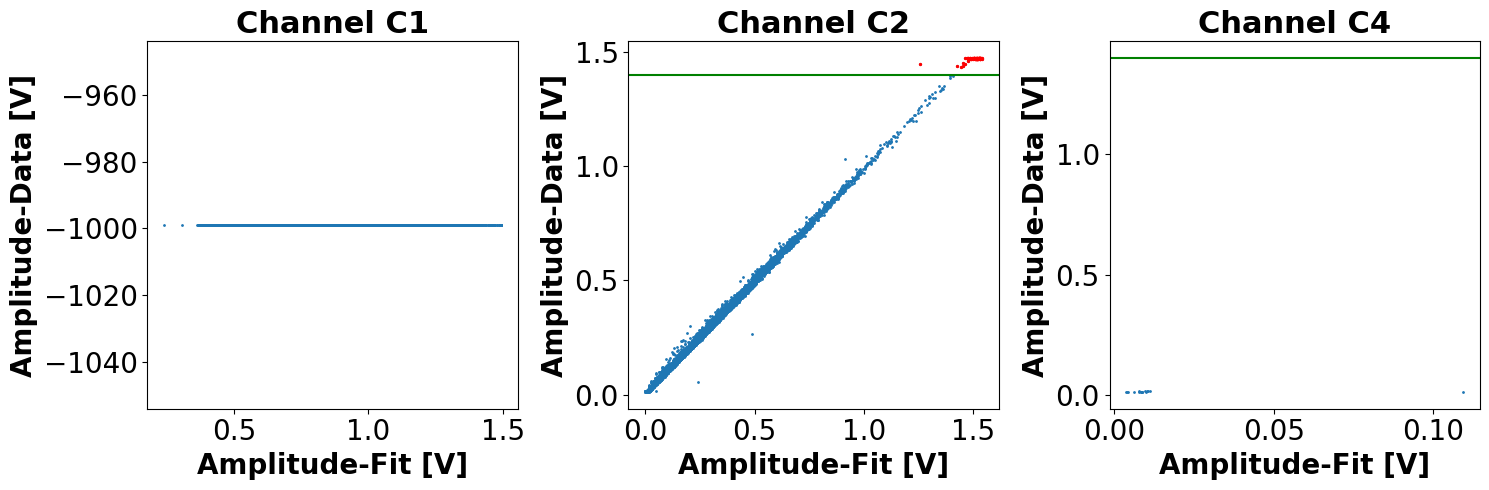

In [19]:
channels = filters.keys()  # Get all available channels
num_channels = len(channels)

fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(5*num_channels, 5))

if num_channels == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

for ax, ch in zip(axes, channels):
    df_filter = df[filters[ch]['ampl_cut']]
    ampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.ampl']
    dampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.dampl']

    df_filter_saturation = df[filters[ch]['ampl_cut'] & ~filters[ch]['saturation_cut']]
    ampl_saturation = df_filter_saturation[f'peakparam_{ch}/peakparam_{ch}.ampl']
    dampl_saturation = df_filter_saturation[f'peakparam_{ch}/peakparam_{ch}.dampl']

    ax.scatter(ampl_filtered, dampl_filtered, s=1)
    ax.scatter(ampl_saturation, dampl_saturation, s=2, color='red', label='Saturation')
    if ch != 'C1':
        ax.axhline(mm_saturation_voltage, color='green', linestyle='-', label='Saturation Voltage')
    ax.set_title(f'Channel {ch}')
    ax.set_xlabel('Amplitude-Fit [V]')
    ax.set_ylabel('Amplitude-Data [V]')
# fig.text(0.5, 0.02, 'Amplitude-Fit [V]', ha='center', fontsize=12)
plt.tight_layout()

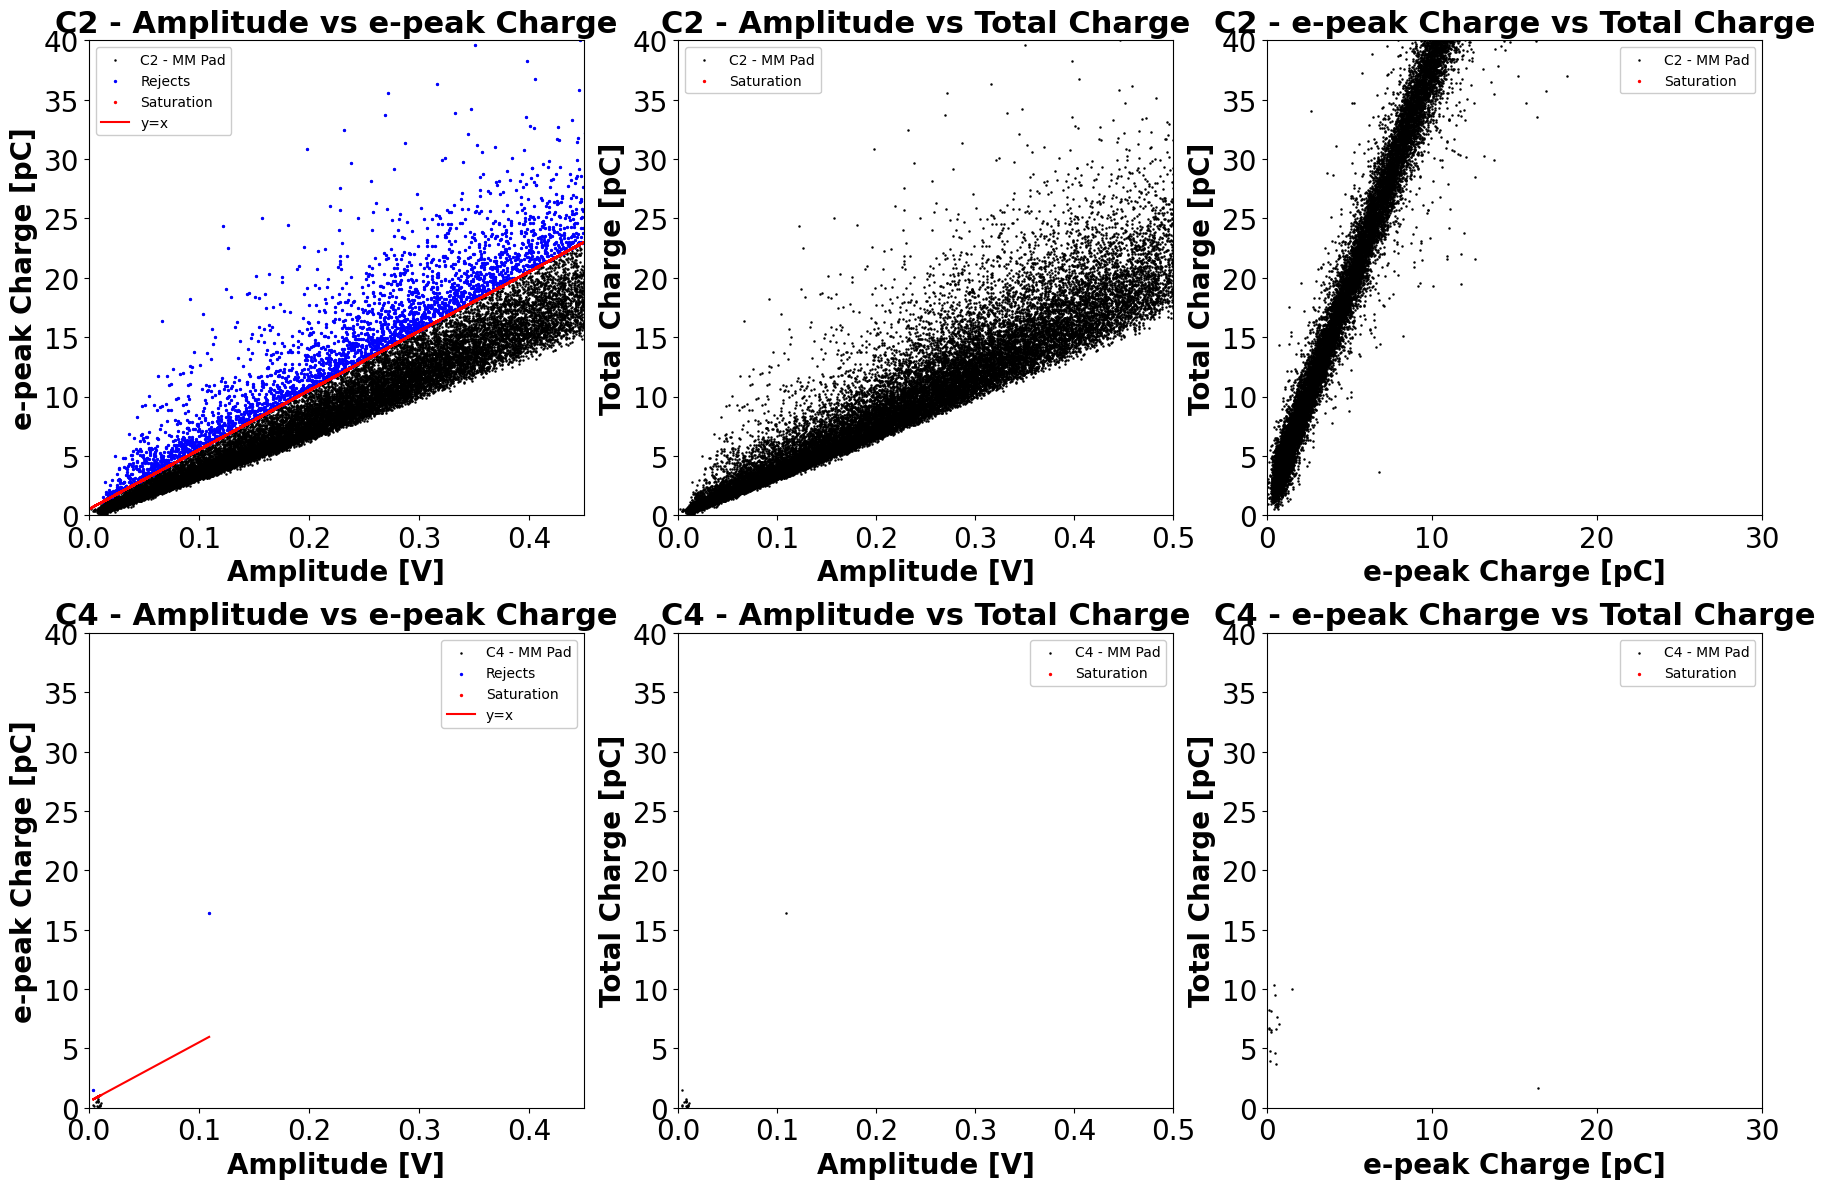

In [38]:
channels = [ch for ch in filters.keys() if ch != 'C1']
num_channels = len(channels)

fig, axs = plt.subplots(nrows=num_channels, ncols=3, figsize=(18, 6*num_channels), sharex=False, sharey=False)

if num_channels == 1:
    axs = [axs]  # Ensure axs is iterable when there's only one channel

# Loop over each channel
for row, ch in enumerate(channels):
    df_filter = df[filters[ch]['ampl_cut']]

    # Extract data
    x_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.ampl']
    y_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.echargefit']

    df_saturation = df[filters[ch]['ampl_cut'] & ~filters[ch]['saturation_cut']]
    x_saturation = df_saturation[f'peakparam_{ch}/peakparam_{ch}.ampl']
    y_saturation = df_saturation[f'peakparam_{ch}/peakparam_{ch}.echargefit']

    # First scatter plot (Amplitude vs e-peak Charge with rejection line)
    up_slope, up_offset = 50, 0.5
    up_rejects_filter = y_filtered > line(x_filtered, up_slope, up_offset)
    up_rejects_x = x_filtered[up_rejects_filter]
    up_rejects_y = y_filtered[up_rejects_filter]

    axs[row, 0].scatter(x_filtered, y_filtered, s=0.6, color='black', label=f'{ch} - MM Pad')
    axs[row, 0].scatter(up_rejects_x, up_rejects_y, s=2, color='blue', label='Rejects')
    axs[row, 0].scatter(x_saturation, y_saturation, s=2, color='red', label='Saturation')
    axs[row, 0].plot(np.array(x_filtered), line(np.array(x_filtered), up_slope, up_offset), color='red', label='y=x')

    axs[row, 0].set_xlabel('Amplitude [V]')
    axs[row, 0].set_ylabel('e-peak Charge [pC]')
    axs[row, 0].set_xlim(0, 0.45)
    axs[row, 0].set_ylim(0, 40)
    axs[row, 0].legend()
    axs[row, 0].set_title(f'{ch} - Amplitude vs e-peak Charge')

    # Second scatter plot (Amplitude vs Total Charge)
    axs[row, 1].scatter(x_filtered, y_filtered, s=0.6, color='black', label=f'{ch} - MM Pad')
    axs[row, 1].scatter(x_saturation, y_saturation, s=2, color='red', label='Saturation')
    axs[row, 1].set_xlabel('Amplitude [V]')
    axs[row, 1].set_ylabel('Total Charge [pC]')
    axs[row, 1].set_xlim(0, 0.5)
    axs[row, 1].set_ylim(0, 40)
    axs[row, 1].legend()
    axs[row, 1].set_title(f'{ch} - Amplitude vs Total Charge')

    # Third scatter plot (e-peak Charge vs Total Charge)
    x_filtered_2 = df_filter[f'peakparam_{ch}/peakparam_{ch}.echargefit']
    y_filtered_2 = df_filter[f'peakparam_{ch}/peakparam_{ch}.totcharge']

    x_saturation_2 = df_saturation[f'peakparam_{ch}/peakparam_{ch}.echargefit']
    y_saturation_2 = df_saturation[f'peakparam_{ch}/peakparam_{ch}.totcharge']

    axs[row, 2].scatter(x_filtered_2, y_filtered_2, s=0.6, color='black', label=f'{ch} - MM Pad')
    axs[row, 2].scatter(x_saturation_2, y_saturation_2, s=2, color='red', label='Saturation')
    axs[row, 2].set_xlabel('e-peak Charge [pC]')
    axs[row, 2].set_ylabel('Total Charge [pC]')
    axs[row, 2].set_xlim(0, 30)
    axs[row, 2].set_ylim(0, 40)
    axs[row, 2].legend()
    axs[row, 2].set_title(f'{ch} - e-peak Charge vs Total Charge')

plt.tight_layout()
plt.show()

# Get the pad center using the charge weighted method

bin_x_min: 1.5585273724269522, bin_x_max: 99.73746261320586
bin_y_min: 1.0321409371563552, bin_y_max: 97.61797538913777


(None, None)

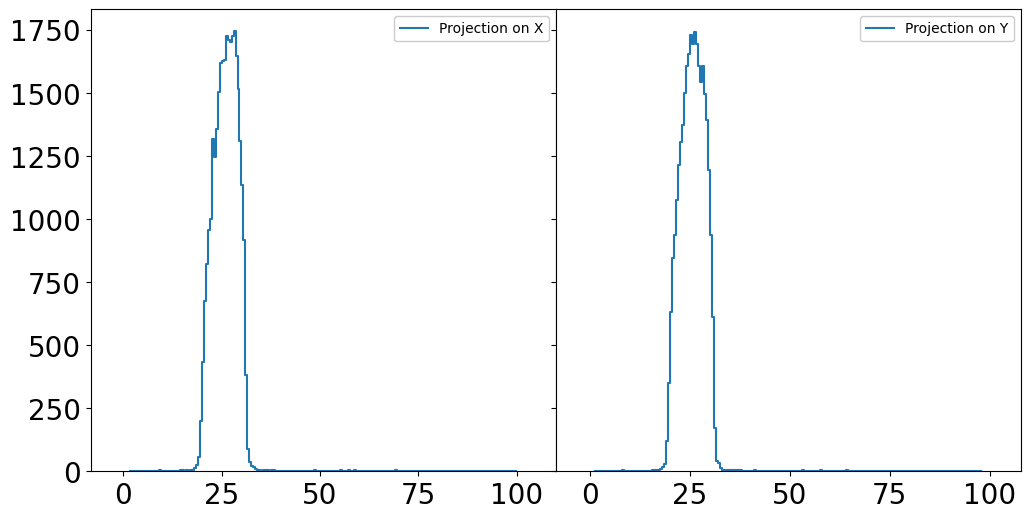

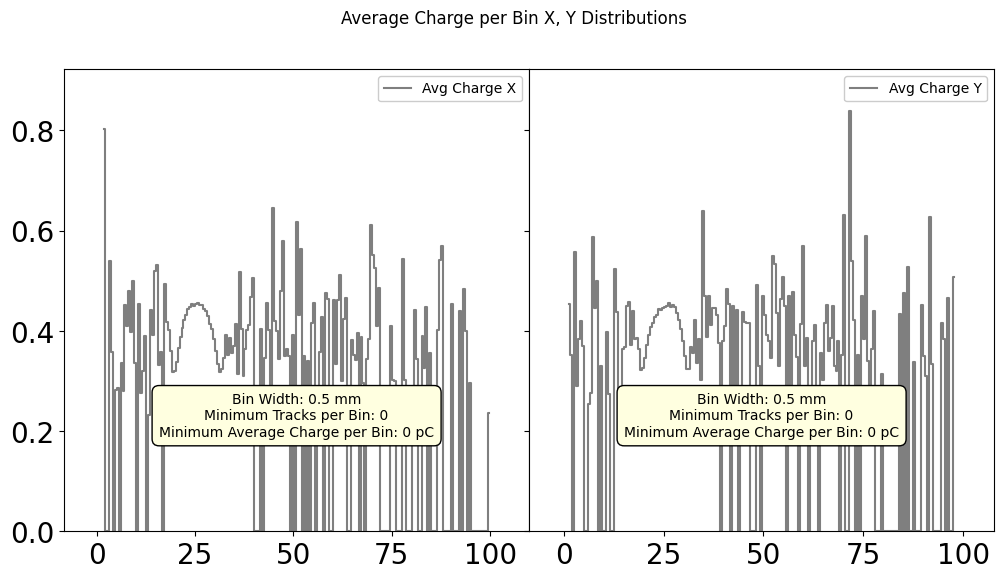

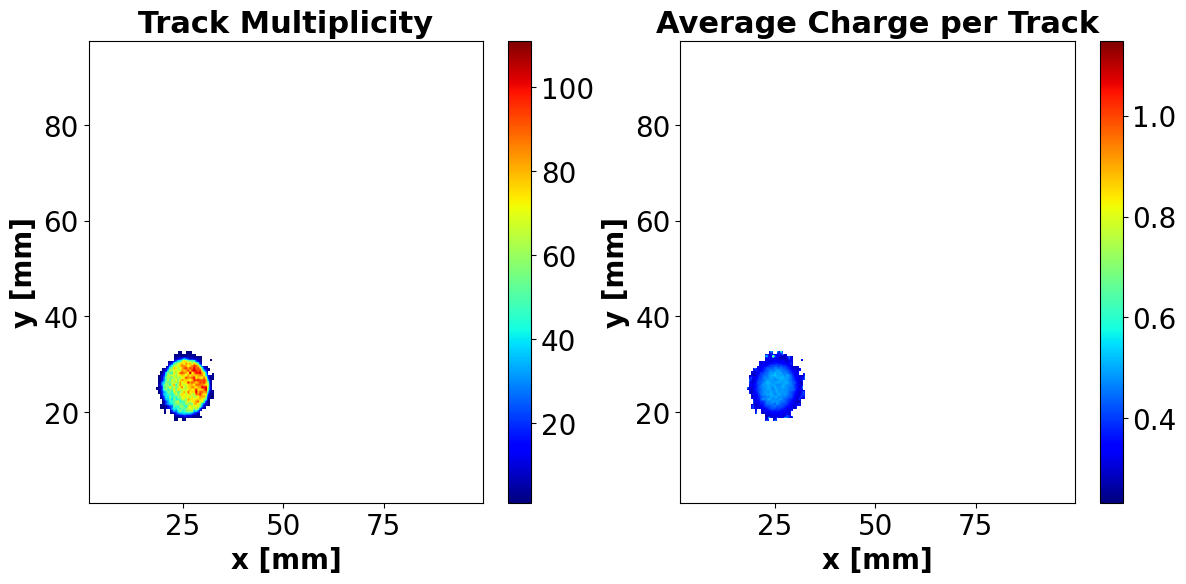

In [21]:
df_filter = df[filters['C1']['charge_cut'] & filters['C1']['xy_cut']]
xs_c1_filtered = df_filter['hitX_C1']
ys_c1_filtered = df_filter['hitY_C1']
charges_c1_filtered = df_filter['peakparam_C1/peakparam_C1.charge']
# print(xs_c1_filtered.head(200))
get_pad_center(charges_c1_filtered, xs_c1_filtered, ys_c1_filtered, min_tracks_per_2d_bin=0, min_avg_charge_per_2d_bin=0, plot=True, plot_only=True)

bin_x_min: 1.5585273724269522, bin_x_max: 99.73746261320586
bin_y_min: 1.0321409371563552, bin_y_max: 97.61797538913777
C1 Pad Center: (25.485 ± 0.093, 25.394 ± 0.081)


/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:329: RuntimeWarning: invalid value encountered in divide
  avg_x_charge_err = np.where(sum_x_tracks > 0, np.abs(avg_x_charge) / np.sqrt(sum_x_tracks), 1)
/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:331: RuntimeWarning: invalid value encountered in divide
  avg_y_charge_err = np.where(sum_y_tracks > 0, np.abs(avg_y_charge) / np.sqrt(sum_y_tracks), 1)


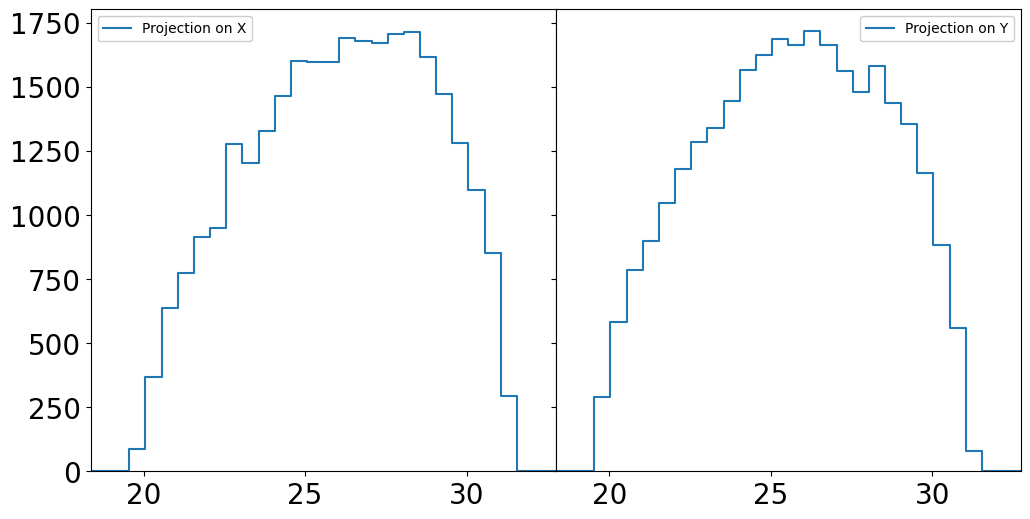

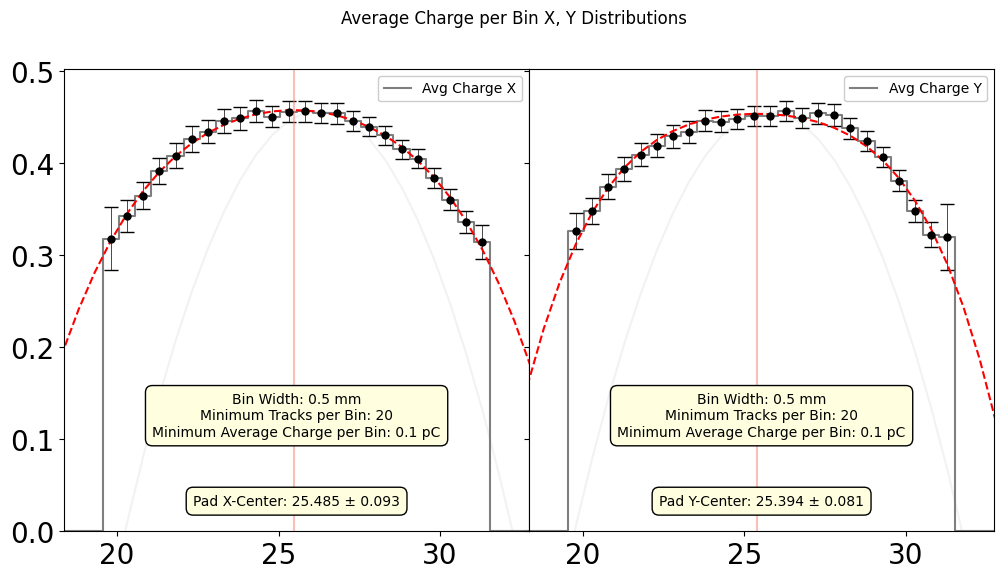

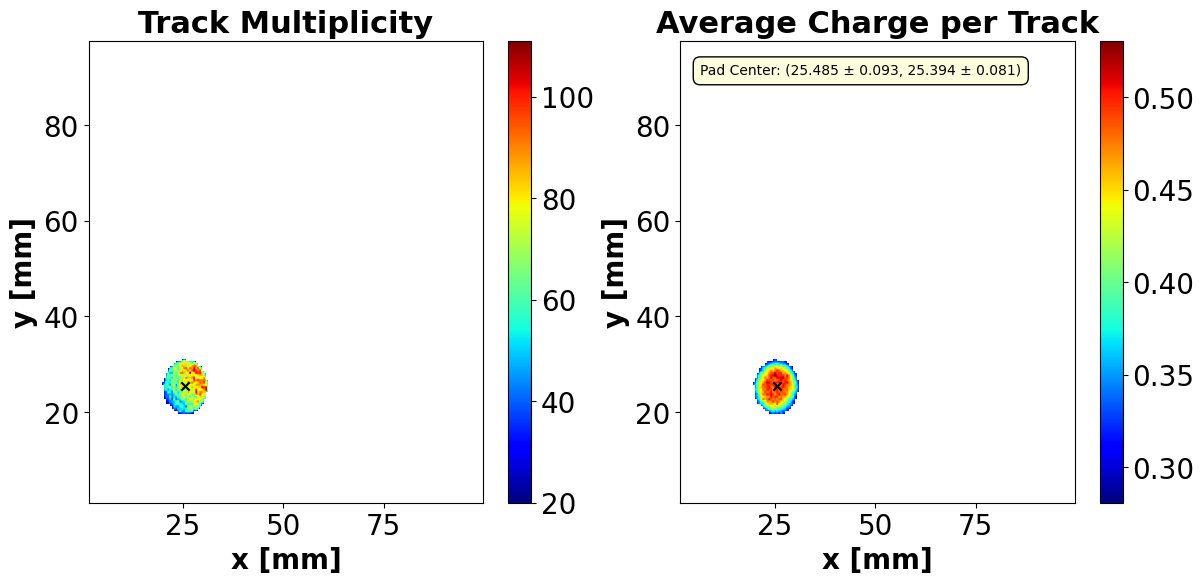

In [22]:
c1_pad_center_measures = get_pad_center(charges_c1_filtered, xs_c1_filtered, ys_c1_filtered,min_avg_charge_per_2d_bin=0.1, plot=True, plot_only=False)
print(f'C1 Pad Center: ({", ".join([str(xi) for xi in c1_pad_center_measures])})')

bin_x_min: -4.985238403117844, bin_x_max: 30.207957648540724
bin_y_min: -30.56932087887901, bin_y_max: 22.275150655693544


(None, None)

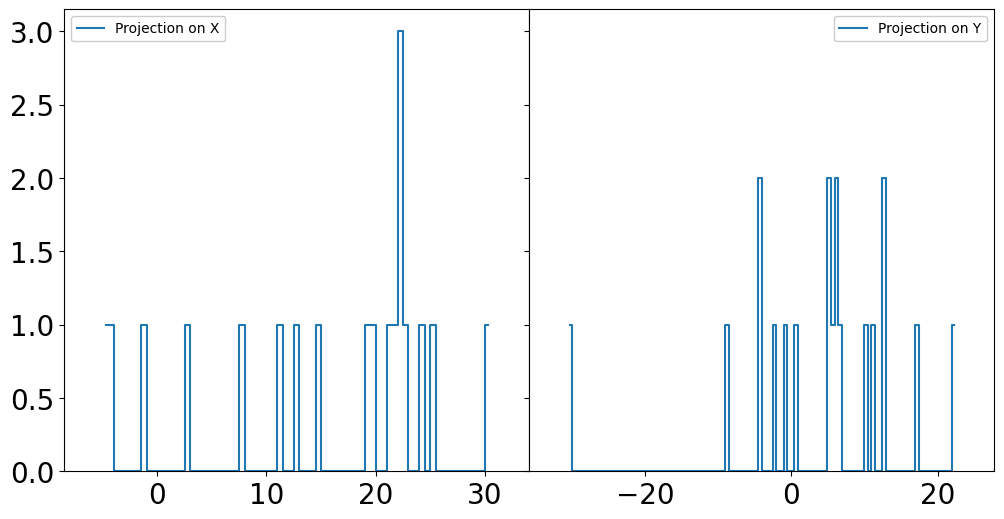

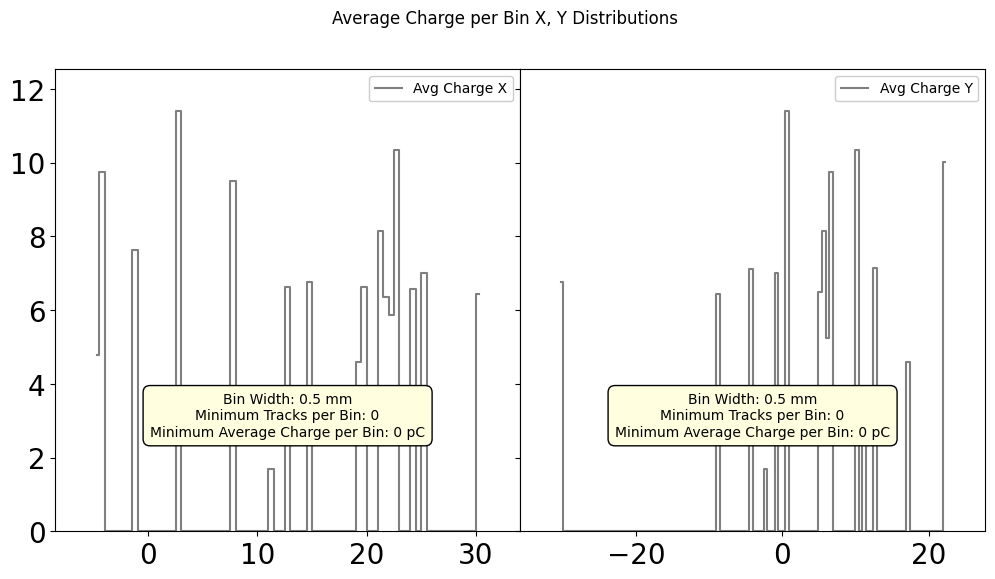

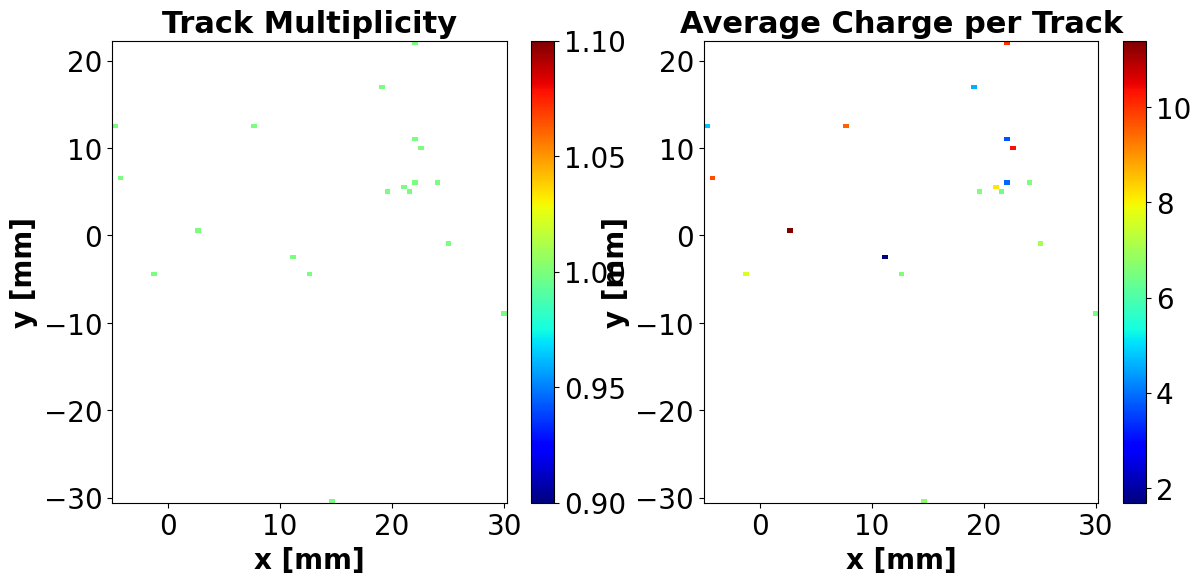

In [23]:
df_filter = df[filters['C4']['totcharge_cut'] & filters['C4']['xy_cut'] & filters['C4']['saturation_cut']]
xs_c4_filtered = df_filter['hitX_C4']
ys_c4_filtered = df_filter['hitY_C4']
charges_c4_filtered = df_filter['peakparam_C4/peakparam_C4.totcharge']
get_pad_center(charges_c4_filtered, xs_c4_filtered, ys_c4_filtered, min_tracks_per_2d_bin=0, min_avg_charge_per_2d_bin=0, plot=True, plot_only=True)

# get_pad_center(df, 'C4', plot=True, charge_cut_low=0, charge_cut_high=100, min_tracks_per_2d_bin=0, min_avg_charge_per_2d_bin=0, plot_only=True)

# C2 Channel

bin_x_min: -20.70329128214764, bin_x_max: 87.59948259268509
bin_y_min: -28.164459460894655, bin_y_max: 91.16074864625644


(None, None)

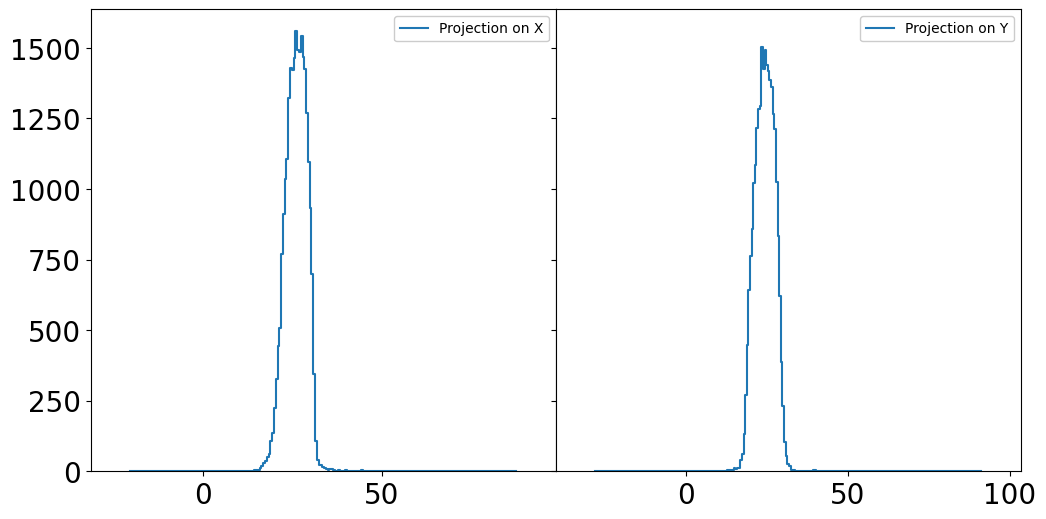

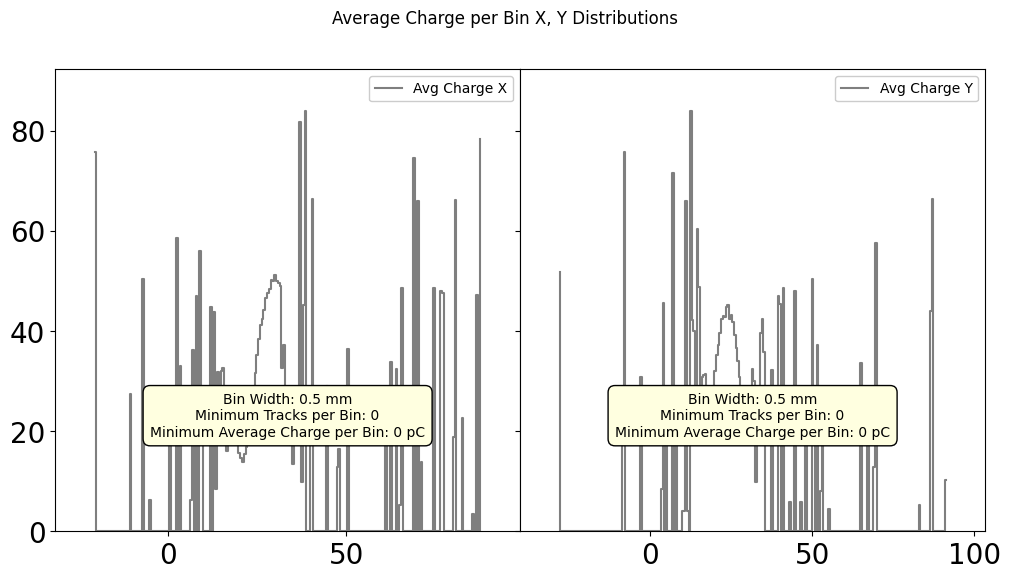

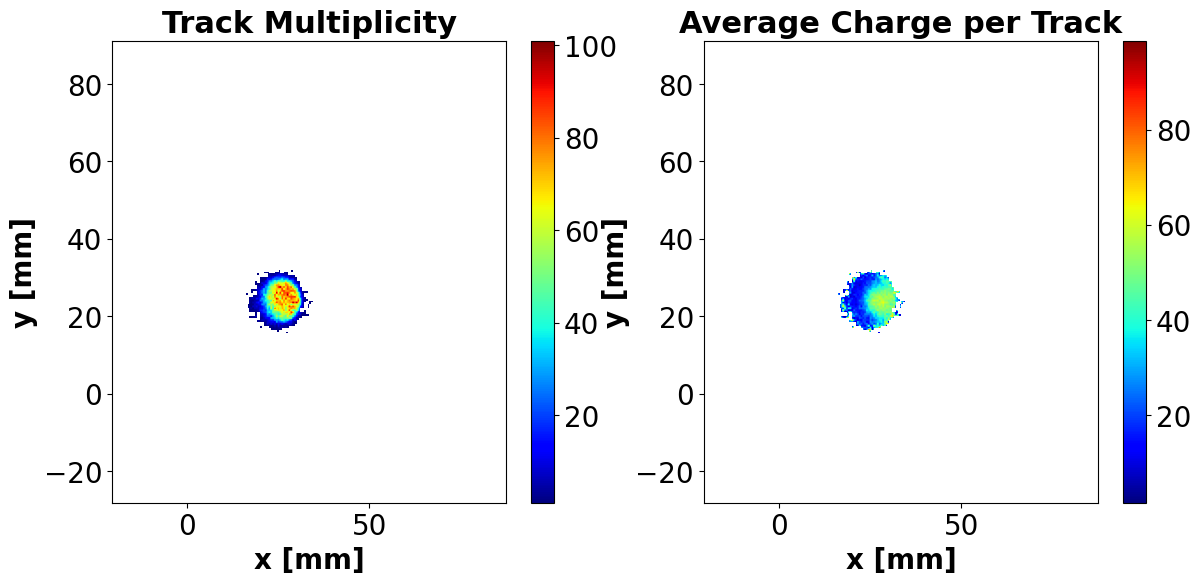

In [24]:
df_filter = df[filters['C2']['totcharge_cut'] & filters['C2']['xy_cut'] & filters['C2']['saturation_cut']]
xs_c2_filtered = df_filter['hitX_C2']
ys_c2_filtered = df_filter['hitY_C2']
charges_c2_filtered = df_filter['peakparam_C2/peakparam_C2.totcharge']
get_pad_center(charges_c2_filtered, xs_c2_filtered, ys_c2_filtered, min_tracks_per_2d_bin=0, min_avg_charge_per_2d_bin=0, plot=True, plot_only=True)


bin_x_min: -20.70329128214764, bin_x_max: 87.59948259268509
bin_y_min: -28.164459460894655, bin_y_max: 91.16074864625644
C2 Pad Center: (32.2 ± 9.3, 23.919 ± 0.077)


/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:329: RuntimeWarning: invalid value encountered in divide
  avg_x_charge_err = np.where(sum_x_tracks > 0, np.abs(avg_x_charge) / np.sqrt(sum_x_tracks), 1)
/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:331: RuntimeWarning: invalid value encountered in divide
  avg_y_charge_err = np.where(sum_y_tracks > 0, np.abs(avg_y_charge) / np.sqrt(sum_y_tracks), 1)


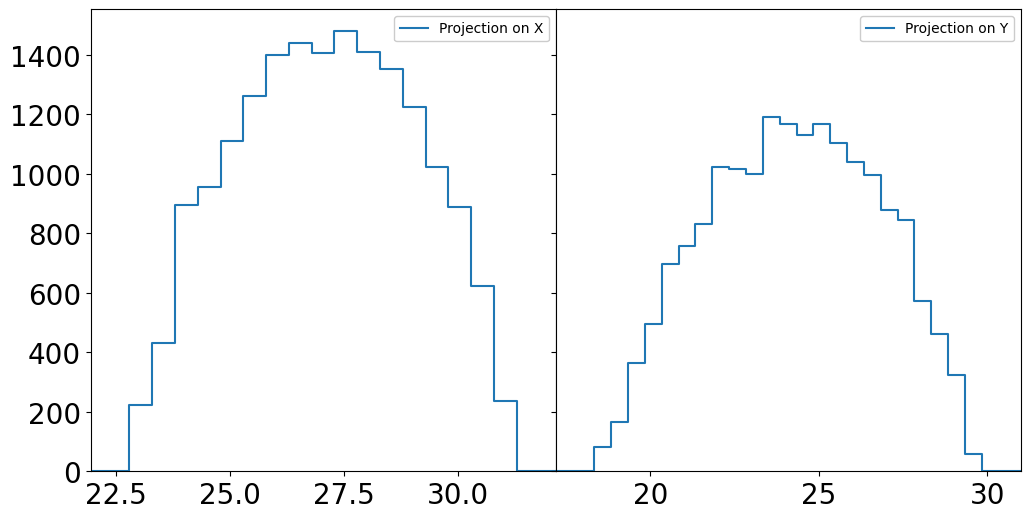

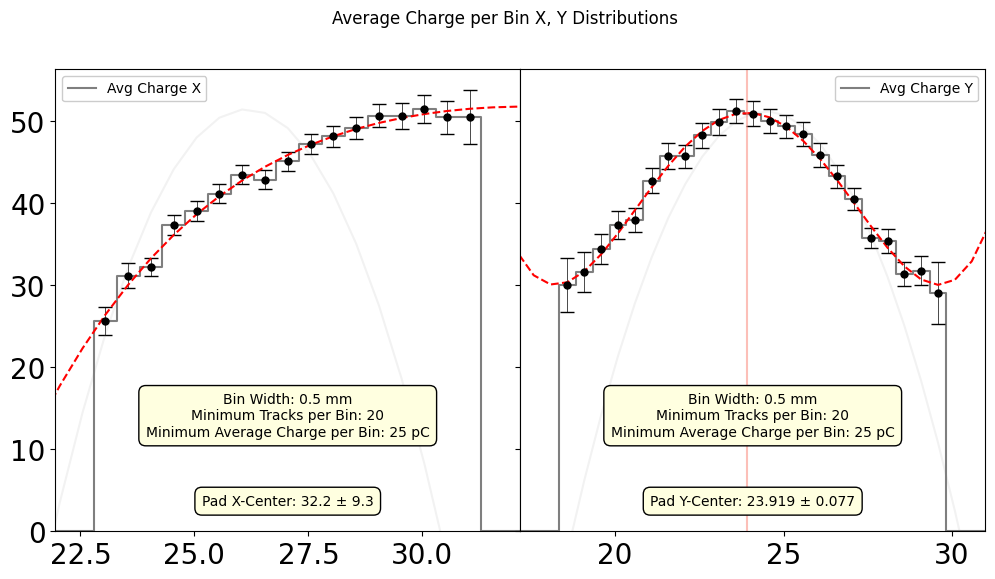

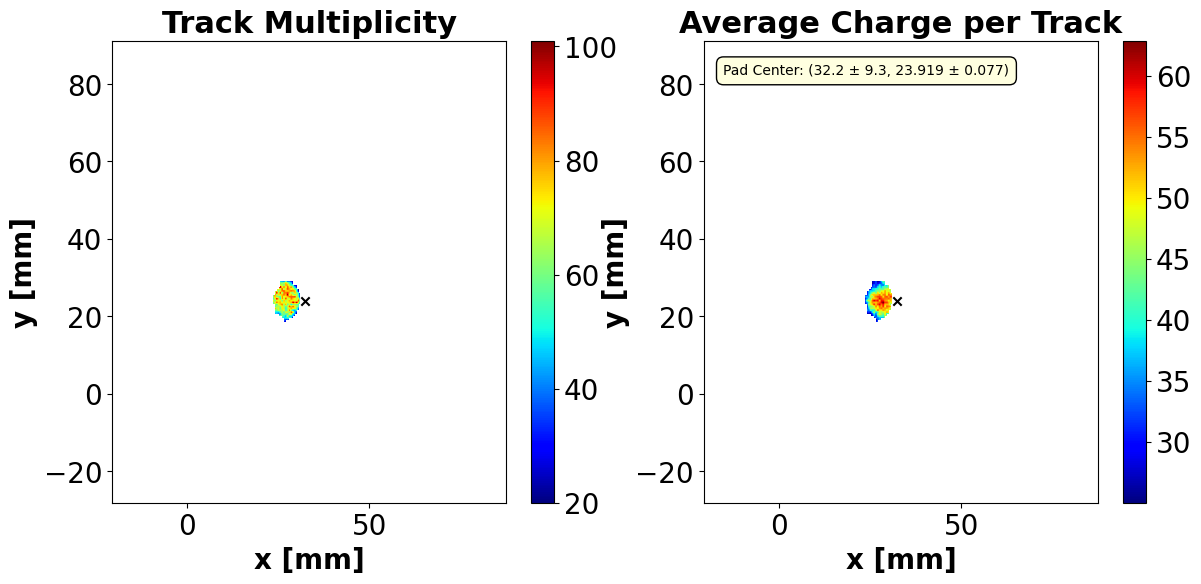

In [50]:
c2_pad_center_measures=get_pad_center(charges_c2_filtered, xs_c2_filtered, ys_c2_filtered, min_avg_charge_per_2d_bin=25, min_tracks_per_2d_bin=20, plot=True)
print(f'C2 Pad Center: ({", ".join([str(xi) for xi in c2_pad_center_measures])})')

df['hitR_C2'] = np.sqrt((df['hitX_C2'] - c2_pad_center_measures[0].val)**2 + (df['hitY_C2'] - c2_pad_center_measures[1].val)**2)
r_inner = 4.3
r_outer = hex_radius_inner_to_outer(r_inner)
filters['C2'].update({'r_cut': df['hitR_C2'] < r_outer})

# C4 Channel

bin_x_min: -4.985238403117844, bin_x_max: 30.207957648540724
bin_y_min: -30.56932087887901, bin_y_max: 22.275150655693544
C4 Pad Center: (20 ± inf, 6 ± inf)


/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:329: RuntimeWarning: invalid value encountered in divide
  avg_x_charge_err = np.where(sum_x_tracks > 0, np.abs(avg_x_charge) / np.sqrt(sum_x_tracks), 1)
/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:331: RuntimeWarning: invalid value encountered in divide
  avg_y_charge_err = np.where(sum_y_tracks > 0, np.abs(avg_y_charge) / np.sqrt(sum_y_tracks), 1)
/home/akallits/PycharmProjects/PicoAnalysis/venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:402: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0].set_ylim(bottom=0, top=np.max(avg_x_charge) * 1.1)
/hom

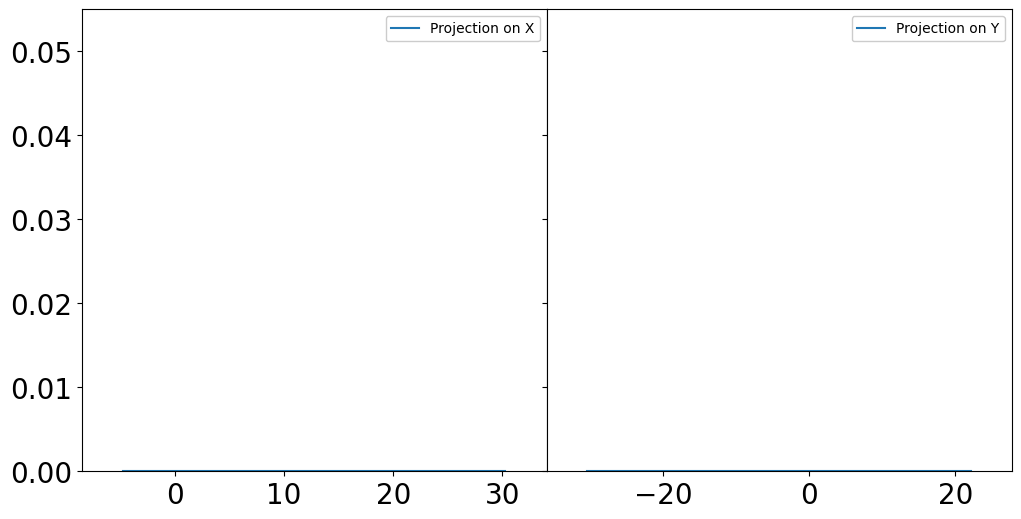

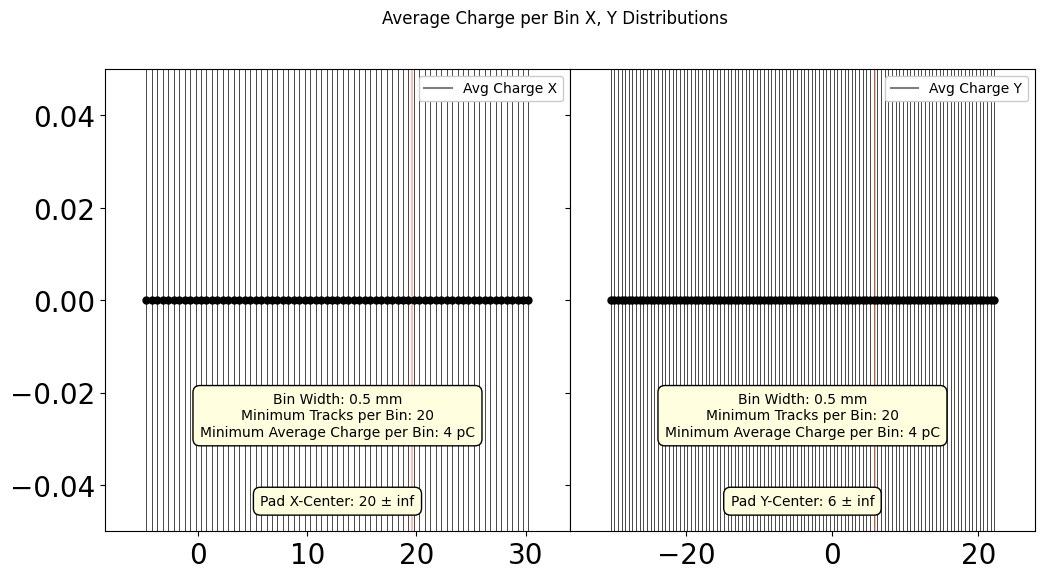

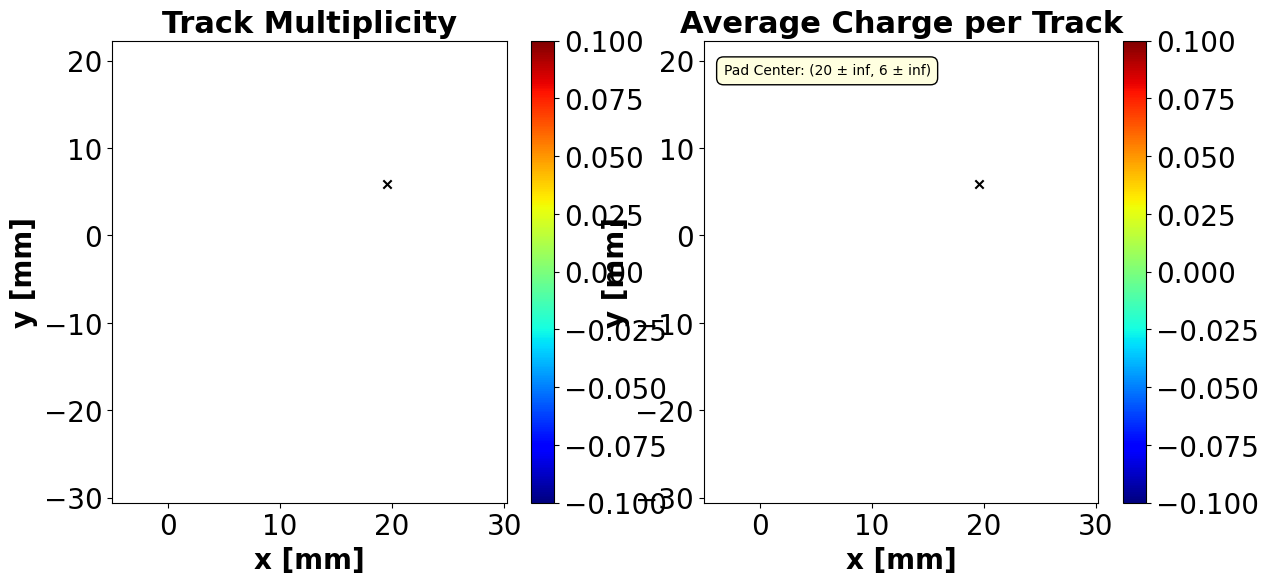

In [26]:
c4_pad_center_measures=get_pad_center(charges_c4_filtered, xs_c4_filtered, ys_c4_filtered, plot=True)
print(f'C4 Pad Center: ({", ".join([str(xi) for xi in c4_pad_center_measures])})')

df['hitR_C4'] = np.sqrt((df['hitX_C4'] - c4_pad_center_measures[0].val)**2 + (df['hitY_C4'] - c4_pad_center_measures[1].val)**2)
r_inner = 4.3
r_outer = hex_radius_inner_to_outer(r_inner)
filters['C4'].update({'r_cut': df['hitR_C4'] < r_outer})

# Get the time walk parameterization raw data

# C2 channel


n_event_bins: 250


/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:458: RuntimeWarning: overflow encountered in exp
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c
/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:458: RuntimeWarning: overflow encountered in multiply
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c
/home/akallits/PycharmProjects/PicoAnalysis/venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:458: RuntimeWarning: invalid value encountered in add
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c


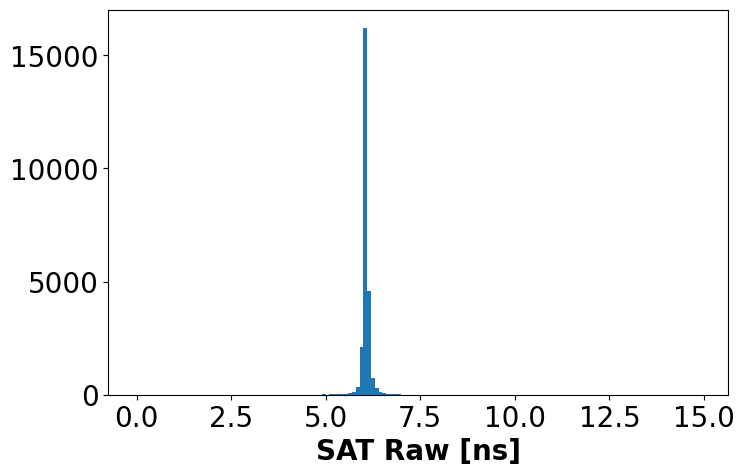

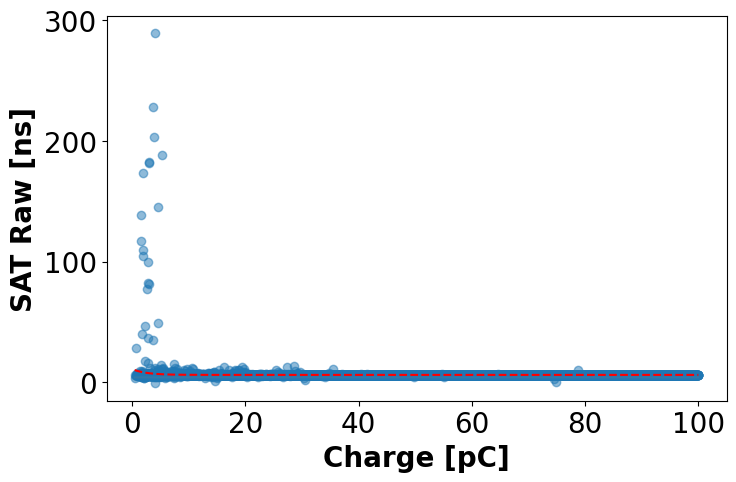

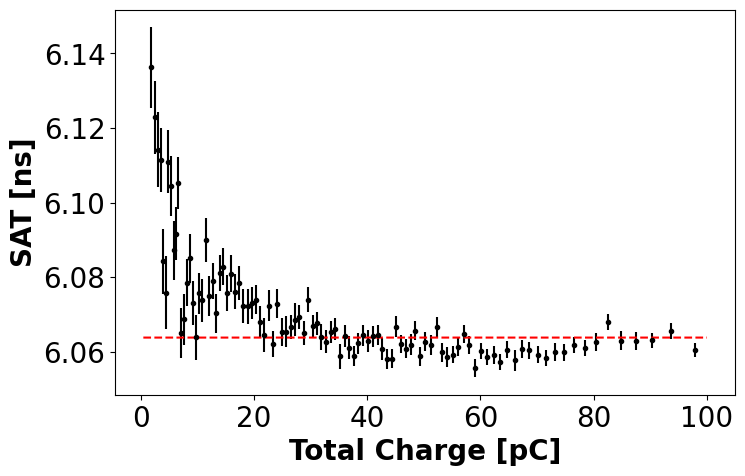

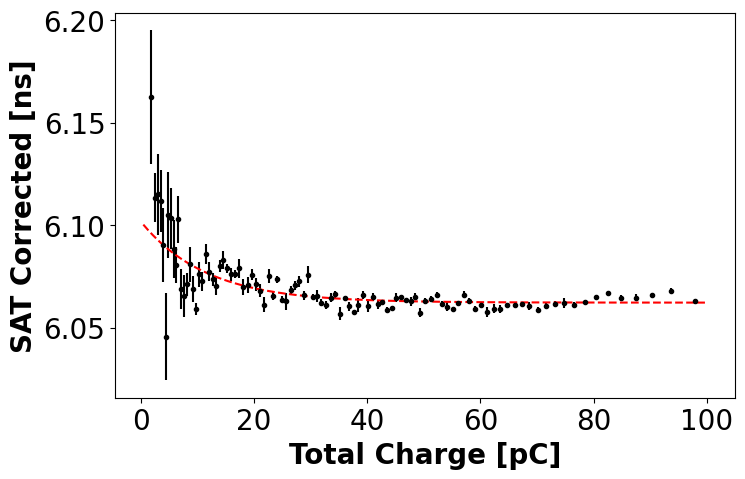

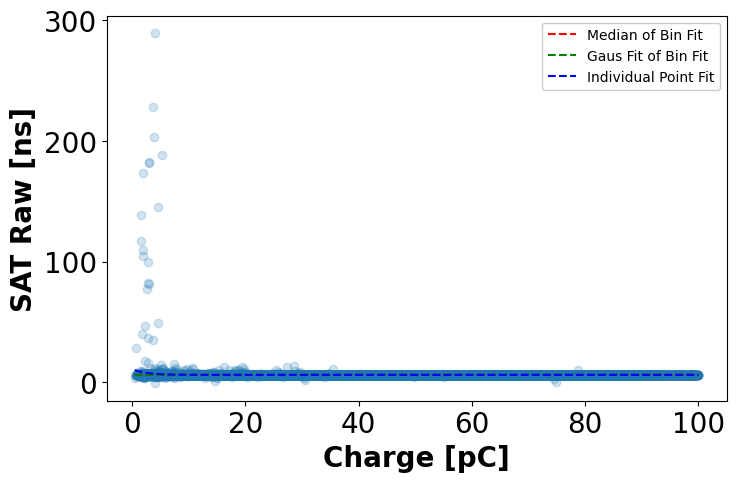

In [27]:
df_filter_C2 = df[(filters['C2']['totcharge_cut']) & (filters['C2']['xy_cut'])]
charges_C2 = df_filter_C2['peakparam_C2/peakparam_C2.totcharge']
time_diff_C2 = df_filter_C2[f'C2_time_diff']

time_walk_func_C2 = time_walk_double_exponential
p0 = [1, -1, -1, -1, 4]

indiv_params, med_bins_params, gaus_bins_params = get_time_walk_parameterization(time_diff_C2, charges_C2, time_walk_func_C2, p0, percentile_cut=(2, 98), plot=True, plot_indiv_fits=False)

(array([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00, 6.0000e+00,
        4.0000e+00, 6.0000e+00, 6.0000e+00, 6.0000e+00, 1.8000e+01,
        1.8000e+01, 2.6000e+01, 7.7000e+01, 2.0500e+02, 2.4210e+03,
        2.0772e+04, 1.0530e+03, 1.9700e+02, 6.5000e+01, 2.6000e+01,
        1.4000e+01, 9.0000e+00, 9.0000e+00, 6.0000e+00, 4.0000e+00,
        1.0000e+01, 1.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00,
        4.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5

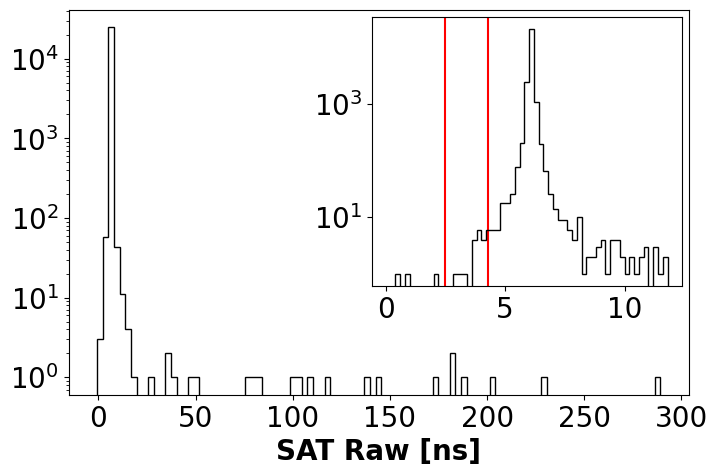

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
binning_t20_diff_C2 = np.linspace(np.min(time_diff_C2), np.max(time_diff_C2), 100)
ax.hist(time_diff_C2, bins=binning_t20_diff_C2, histtype='step', color='black')
#make y-axis log scale
ax.set_yscale('log')
ax.set_xlabel('SAT Raw [ns]')

# Create an inset axis
ax_inset = inset_axes(ax, width="50%", height="70%", loc="upper right")  # % of parent axis

# Inset plot data
binning_t20_diff_nom = np.arange(0, 12, 0.2)
ax_inset.axvline(2.5, color='red', ls='-')
ax_inset.axvline(4.3, color='red', ls='-')
ax_inset.set_yscale('log')
ax_inset.hist(time_diff_C2, bins=binning_t20_diff_nom, histtype='step', color='black')

# C4 channel

n_event_bins: 0
No events in bin 0 (1.69 pC to 2.05 pC)
No events in bin 1 (2.05 pC to 2.42 pC)
No events in bin 2 (2.42 pC to 2.78 pC)
No events in bin 3 (2.78 pC to 3.14 pC)
No events in bin 4 (3.14 pC to 3.51 pC)
Only one event in bin 5 (3.51 pC to 3.72 pC)
No events in bin 6 (3.72 pC to 3.76 pC)
No events in bin 7 (3.76 pC to 3.80 pC)
No events in bin 8 (3.80 pC to 3.83 pC)
No events in bin 9 (3.83 pC to 3.87 pC)
No events in bin 10 (3.87 pC to 3.90 pC)
No events in bin 11 (3.90 pC to 4.02 pC)
No events in bin 12 (4.02 pC to 4.14 pC)
No events in bin 13 (4.14 pC to 4.26 pC)
No events in bin 14 (4.26 pC to 4.38 pC)
No events in bin 15 (4.38 pC to 4.50 pC)
Only one event in bin 16 (4.50 pC to 4.59 pC)
No events in bin 17 (4.59 pC to 4.63 pC)
No events in bin 18 (4.63 pC to 4.67 pC)
No events in bin 19 (4.67 pC to 4.71 pC)
No events in bin 20 (4.71 pC to 4.74 pC)
No events in bin 21 (4.74 pC to 4.78 pC)
Only one event in bin 22 (4.78 pC to 5.01 pC)
No events in bin 23 (5.01 pC to 5.29

/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:458: RuntimeWarning: overflow encountered in exp
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c


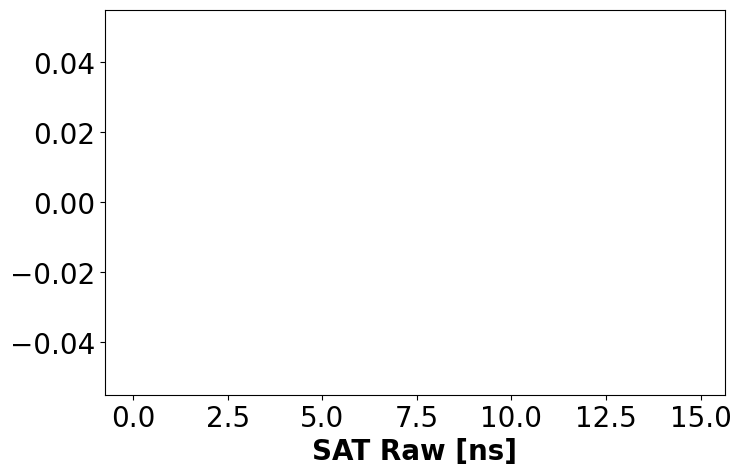

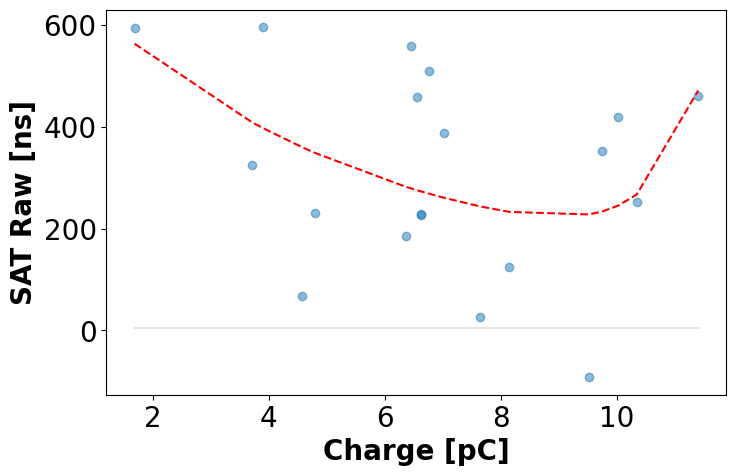

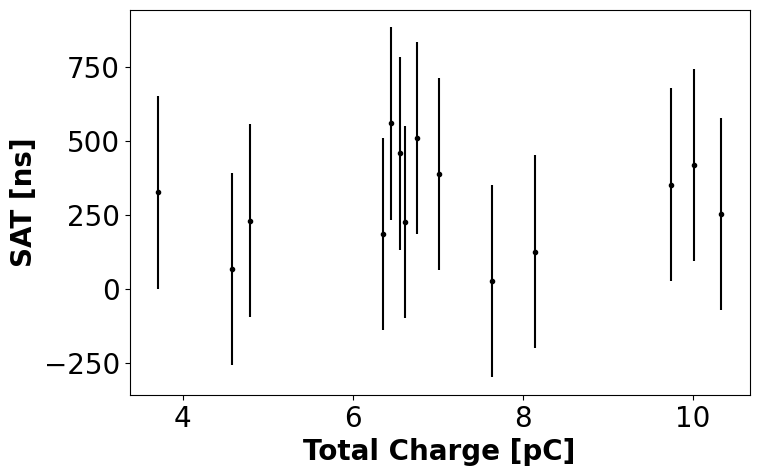

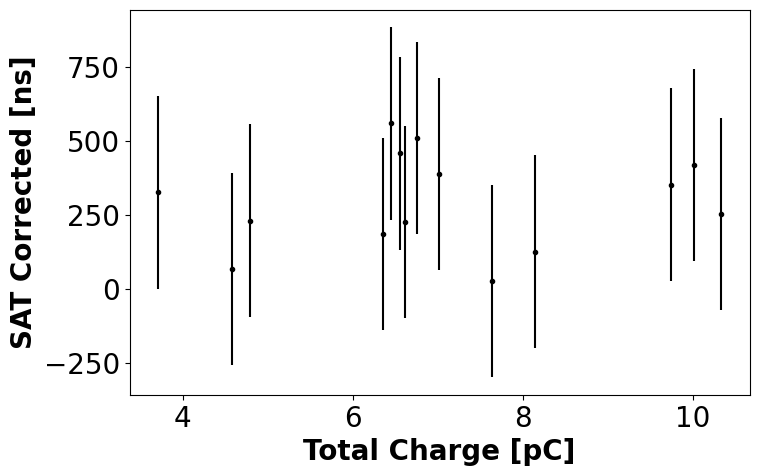

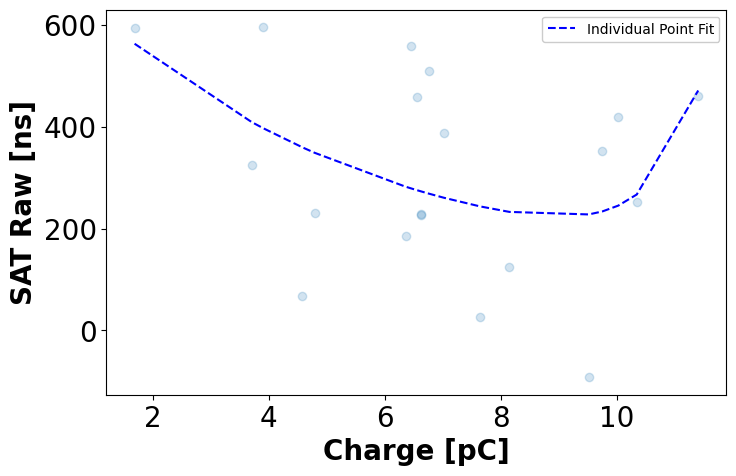

In [29]:
df_filter = df[(filters['C4']['totcharge_cut']) & (filters['C4']['xy_cut'])]
charges = df_filter['peakparam_C4/peakparam_C4.totcharge']
time_diff = df_filter[f'C4_time_diff']

time_walk_func = time_walk_double_exponential
p0 = [1, -1, -1, -1, 4]

indiv_params, med_bins_params, gaus_bins_params = get_time_walk_parameterization(time_diff, charges, time_walk_func, p0, percentile_cut=(2, 98), plot=True, plot_indiv_fits=False)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
         6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
         8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
        11. , 11.2, 11.4, 11.6, 11.8]),
 [<matplotlib.patches.Polygon at 0x7f06717d14c0>])

/home/akallits/PycharmProjects/PicoAnalysis/venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


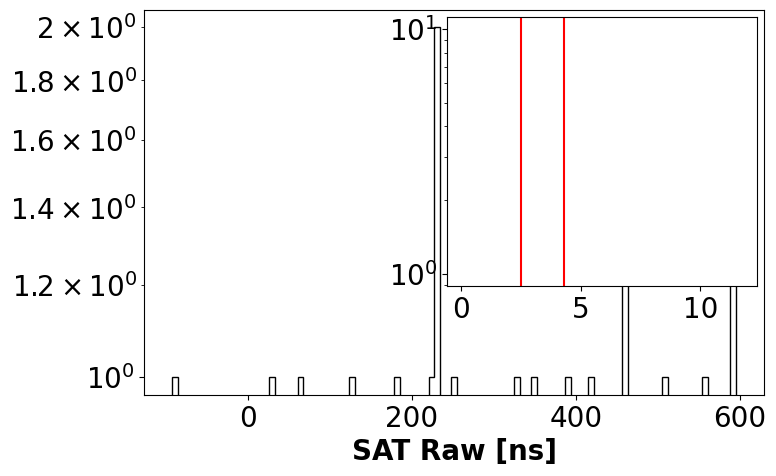

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))
binning_t20_diff = np.linspace(np.min(time_diff), np.max(time_diff), 100)
ax.hist(time_diff, bins=binning_t20_diff, histtype='step', color='black')
#make y-axis log scale
ax.set_yscale('log')
ax.set_xlabel('SAT Raw [ns]')

# Create an inset axis
ax_inset = inset_axes(ax, width="50%", height="70%", loc="upper right")  # % of parent axis

# Inset plot data
binning_t20_diff_nom = np.arange(0, 12, 0.2)
ax_inset.axvline(2.5, color='red', ls='-')
ax_inset.axvline(4.3, color='red', ls='-')
ax_inset.set_yscale('log')
ax_inset.hist(time_diff, bins=binning_t20_diff_nom, histtype='step', color='black')

# Time walk parameterization with radial cut

# C2 channel

In [31]:
df_filter_C2 = df[filters['C2']['totcharge_cut'] & filters['C2']['xy_cut'] & filters['C2']['r_cut'] & filters['C2']['saturation_cut']]
charges_C2 = df_filter_C2['peakparam_C2/peakparam_C2.totcharge']
time_diff_C2 = df_filter_C2[f'C2_time_diff']
xs_C2 = df_filter_C2['hitX_C2']
ys_C2 = df_filter_C2['hitY_C2']
rs_C2 = df_filter_C2['hitR_C2']

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
         6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
         8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
        11. , 11.2, 11.4, 11.6, 11.8]),
 [<matplotlib.patches.Polygon at 0x7f066a3faa00>])

/home/akallits/PycharmProjects/PicoAnalysis/venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


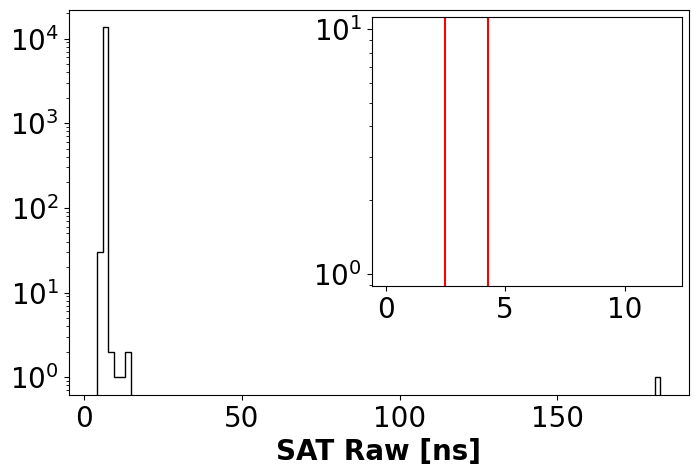

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
binning_t20_diff = np.linspace(np.min(time_diff_C2), np.max(time_diff_C2), 100)
ax.hist(time_diff_C2, bins=binning_t20_diff, histtype='step', color='black')
#make y-axis log scale
ax.set_yscale('log')
ax.set_xlabel('SAT Raw [ns]')

# Create an inset axis
ax_inset = inset_axes(ax, width="50%", height="70%", loc="upper right")  # % of parent axis

# Inset plot data
binning_t20_diff_nom = np.arange(0, 12, 0.2)
ax_inset.axvline(2.5, color='red', ls='-')
ax_inset.axvline(4.3, color='red', ls='-')
ax_inset.set_yscale('log')
ax_inset.hist(time_diff, bins=binning_t20_diff_nom, histtype='step', color='black')

# C4 Channel

In [33]:
df_filter = df[filters['C4']['totcharge_cut'] & filters['C4']['xy_cut'] & filters['C4']['r_cut'] & filters['C4']['saturation_cut']]
charges = df_filter['peakparam_C4/peakparam_C4.totcharge']
time_diff = df_filter[f'C4_time_diff']
xs = df_filter['hitX_C4']
ys = df_filter['hitY_C4']
rs = df_filter['hitR_C4']

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
         6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
         8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
        11. , 11.2, 11.4, 11.6, 11.8]),
 [<matplotlib.patches.Polygon at 0x7f066bc2cd00>])

/home/akallits/PycharmProjects/PicoAnalysis/venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


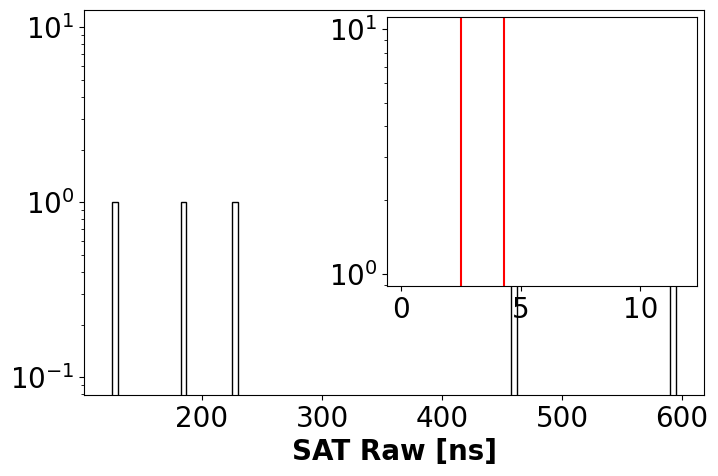

In [34]:
fig, ax = plt.subplots(figsize=(8, 5))
binning_t20_diff = np.linspace(np.min(time_diff), np.max(time_diff), 100)
ax.hist(time_diff, bins=binning_t20_diff, histtype='step', color='black')
#make y-axis log scale
ax.set_yscale('log')
ax.set_xlabel('SAT Raw [ns]')

# Create an inset axis
ax_inset = inset_axes(ax, width="50%", height="70%", loc="upper right")  # % of parent axis

# Inset plot data
binning_t20_diff_nom = np.arange(0, 12, 0.2)
ax_inset.axvline(2.5, color='red', ls='-')
ax_inset.axvline(4.3, color='red', ls='-')
ax_inset.set_yscale('log')
ax_inset.hist(time_diff, bins=binning_t20_diff_nom, histtype='step', color='black')

# Check outliers in the time difference with their track position

# C2 Channel



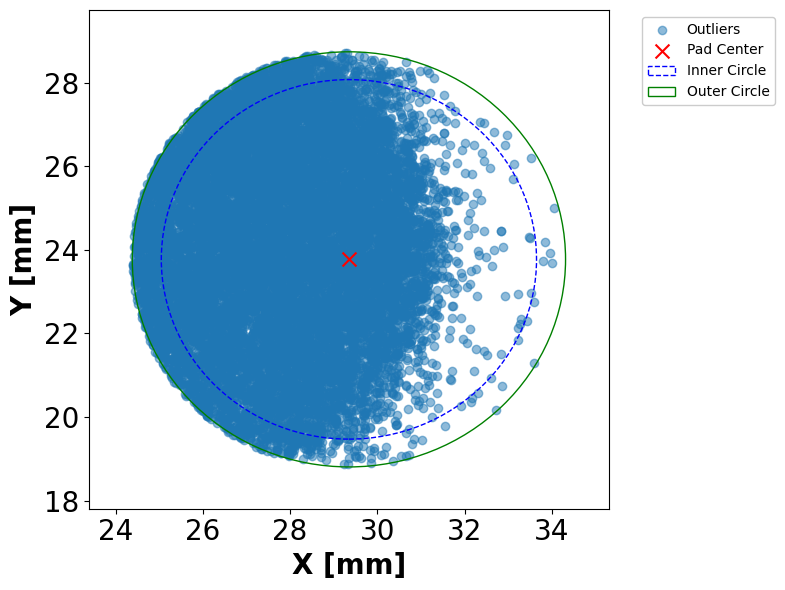

In [35]:
time_diff_mask_C2 = (time_diff_C2 < 2.5) | ( time_diff_C2 > 4.3)
# print(time_diff_mask)
# small_time_diff_mask = time_diff_filter < 2.5
# local_time_diff_mask = np.abs(time_diff_filter) > 4.3 or 7.5

xs_large_time_diff_C2 = xs_C2[time_diff_mask_C2]
ys_large_time_diff_C2 = ys_C2[time_diff_mask_C2]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(xs_large_time_diff_C2, ys_large_time_diff_C2, alpha=0.5, label='Outliers')
ax.scatter(c2_pad_center_measures[0].val, c2_pad_center_measures[1].val,
           color='red', marker='x', s=100, label='Pad Center')

center_x, center_y = c2_pad_center_measures[0].val, c2_pad_center_measures[1].val
inner_circle = patches.Circle((center_x, center_y), r_inner, fill=False, edgecolor='blue', linestyle='dashed', label='Inner Circle')
outer_circle = patches.Circle((center_x, center_y), r_outer, fill=False, edgecolor='green', linestyle='solid', label='Outer Circle')

ax.add_patch(inner_circle)
ax.add_patch(outer_circle)

ax.set_xlim(center_x - r_outer - 1, center_x + r_outer + 1)
ax.set_ylim(center_y - r_outer - 1, center_y + r_outer + 1)

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

n_event_bins: 136


/home/akallits/PycharmProjects/PicoAnalysis/venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:458: RuntimeWarning: overflow encountered in exp
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c
/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:458: RuntimeWarning: invalid value encountered in add
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c
/home/akallits/PycharmProjects/PicoAnalysis/venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:504: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


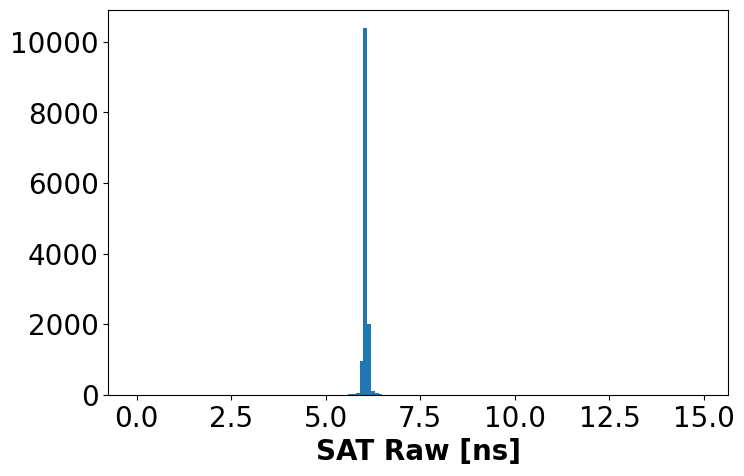

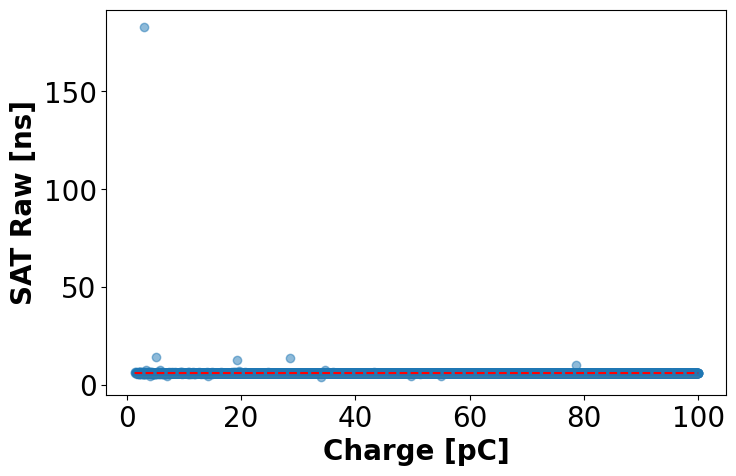

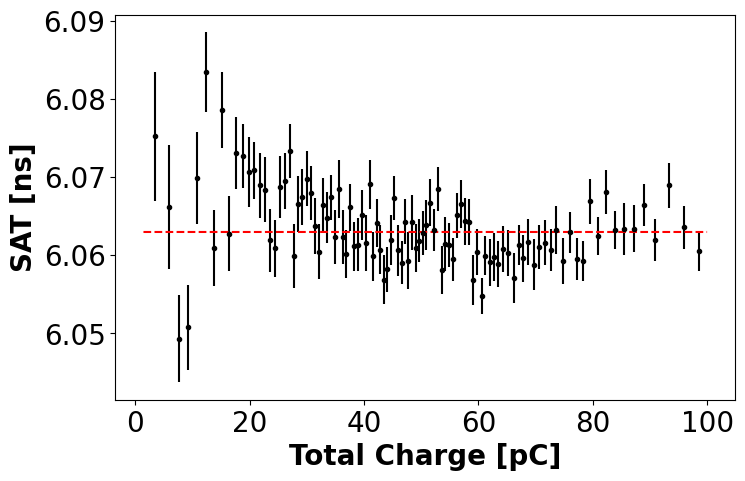

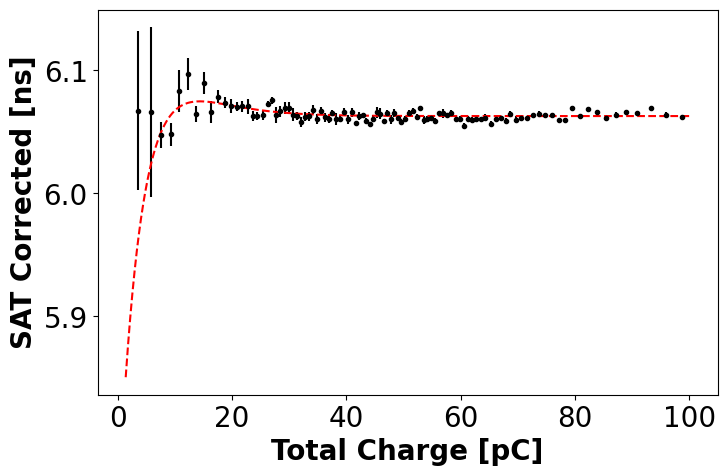

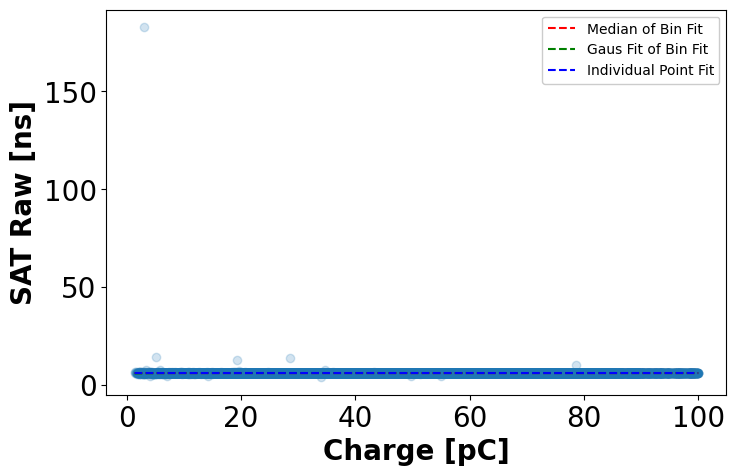

In [36]:
# time_diff_filter, charges_filter = time_diff[~time_diff_mask], charges[~time_diff_mask]
# rs_filter = rs[~time_diff_mask]
# xs_filter = xs[~time_diff_mask]
# ys_filter = ys[~time_diff_mask]
# df_filter = df[filters['C4']['totcharge_cut'] & filters['C4']['xy_cut'] & filters['C4']['r_cut'] & filters['C4']['saturation_cut']]
# charges = df_filter['peakparam_C4/peakparam_C4.totcharge']
# time_diff = df_filter[f'C4_time_diff']
indiv_params_C2, med_bins_params_C2, gaus_bins_params_C2 = get_time_walk_parameterization(time_diff_C2, charges_C2, time_walk_func_C2, p0, percentile_cut=(2, 98), plot=True, plot_indiv_fits=False)

In [37]:
indiv_params_C2, med_bins_params_C2, gaus_bins_params_C2 = get_time_walk_parameterization(time_diff, charges, time_walk_func, p0, percentile_cut=(2, 98), binning_type='equal_steps', plot=True, plot_indiv_fits=True)

No events in bin 0 (3.91 pC to 3.95 pC)
No events in bin 1 (3.95 pC to 3.99 pC)
No events in bin 2 (3.99 pC to 4.03 pC)
No events in bin 3 (4.03 pC to 4.08 pC)
No events in bin 4 (4.08 pC to 4.12 pC)
No events in bin 5 (4.12 pC to 4.16 pC)
No events in bin 6 (4.16 pC to 4.20 pC)
No events in bin 7 (4.20 pC to 4.25 pC)
No events in bin 8 (4.25 pC to 4.29 pC)
No events in bin 9 (4.29 pC to 4.33 pC)
No events in bin 10 (4.33 pC to 4.37 pC)
No events in bin 11 (4.37 pC to 4.42 pC)
No events in bin 12 (4.42 pC to 4.46 pC)
No events in bin 13 (4.46 pC to 4.50 pC)
No events in bin 14 (4.50 pC to 4.54 pC)
No events in bin 15 (4.54 pC to 4.59 pC)
No events in bin 16 (4.59 pC to 4.63 pC)
No events in bin 17 (4.63 pC to 4.67 pC)
No events in bin 18 (4.67 pC to 4.71 pC)
No events in bin 19 (4.71 pC to 4.76 pC)
No events in bin 20 (4.76 pC to 4.80 pC)
No events in bin 21 (4.80 pC to 4.84 pC)
No events in bin 22 (4.84 pC to 4.88 pC)
No events in bin 23 (4.88 pC to 4.92 pC)
No events in bin 24 (4.92 

/home/akallits/Saclay_Analysis/py_analysis/single_pad_analysis/analysis_functions.py:458: RuntimeWarning: overflow encountered in exp
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c
/home/akallits/PycharmProjects/PicoAnalysis/venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


TypeError: The number of func parameters=5 must not exceed the number of data points=3

# C4 channel

In [ ]:
time_diff_mask = (time_diff < 2.5) | ( time_diff > 4.3)
# print(time_diff_mask)
# small_time_diff_mask = time_diff_filter < 2.5
# local_time_diff_mask = np.abs(time_diff_filter) > 4.3 or 7.5

xs_large_time_diff = xs[time_diff_mask]
ys_large_time_diff = ys[time_diff_mask]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(xs_large_time_diff, ys_large_time_diff, alpha=0.5, label='Outliers')
ax.scatter(c4_pad_center_measures[0].val, c4_pad_center_measures[1].val,
           color='red', marker='x', s=100, label='Pad Center')

center_x, center_y = c4_pad_center_measures[0].val, c4_pad_center_measures[1].val
inner_circle = patches.Circle((center_x, center_y), r_inner, fill=False, edgecolor='blue', linestyle='dashed', label='Inner Circle')
outer_circle = patches.Circle((center_x, center_y), r_outer, fill=False, edgecolor='green', linestyle='solid', label='Outer Circle')

ax.add_patch(inner_circle)
ax.add_patch(outer_circle)

ax.set_xlim(center_x - r_outer - 1, center_x + r_outer + 1)
ax.set_ylim(center_y - r_outer - 1, center_y + r_outer + 1)

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

In [ ]:
# time_diff_filter, charges_filter = time_diff[~time_diff_mask], charges[~time_diff_mask]
# rs_filter = rs[~time_diff_mask]
# xs_filter = xs[~time_diff_mask]
# ys_filter = ys[~time_diff_mask]
# df_filter = df[filters['C4']['totcharge_cut'] & filters['C4']['xy_cut'] & filters['C4']['r_cut'] & filters['C4']['saturation_cut']]
# charges = df_filter['peakparam_C4/peakparam_C4.totcharge']
# time_diff = df_filter[f'C4_time_diff']
indiv_params, med_bins_params, gaus_bins_params = get_time_walk_parameterization(time_diff, charges, time_walk_func, p0, percentile_cut=(2, 98), plot=True, plot_indiv_fits=False)

In [ ]:
indiv_params, med_bins_params, gaus_bins_params = get_time_walk_parameterization(time_diff, charges, time_walk_func, p0, percentile_cut=(2, 98), binning_type='equal_steps', plot=True, plot_indiv_fits=True)

# Time walk correction using Indiv point fit, Median of Bin Fit and Gaus of Bin Fit

# C2 Channel


In [ ]:
cor_names = ['Individual Points Fit', 'Median of Bin Fit', 'Gaus Fit of Bin Fit']
for cor_meases, cor_name in zip([indiv_params_C2, med_bins_params_C2, gaus_bins_params_C2], cor_names):
    print(f'{col_name}: {cor_meases}')
    cor_popt = [par.val for par in cor_meases]
    time_diff_cor_C2 = time_diff_C2 - time_walk_func(charges_C2, *cor_popt)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    axs[0].scatter(charges, time_diff_cor_C2, alpha=0.2, label=cor_name)
    axs[0].set_xlabel('Charge [ns]')
    axs[0].set_ylabel('SAT [ns]')
    axs[1].hist(time_diff_cor_C2, bins=100)
    axs[1].set_xlabel('SAT [ns]')
    axs[0].legend()
    fig.subplots_adjust(wspace=0.3)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(rs_C2, time_diff_cor_C2, alpha=0.2, label=cor_name)
    ax.set_xlabel('Radial Distance [mm]')
    ax.set_ylabel('SAT [ns]')
    ax.axvline(r_inner, color='green', ls='--', label='Hex Inner Radius')
    ax.axvline(r_outer, color='orange', ls='--', label='Hex Outer Radius')
    ax.legend()
    ax.set_ylim(-2, 2)
    ax.set_xlim(-1, 10)

# C4 Channel

In [ ]:
cor_names = ['Individual Points Fit', 'Median of Bin Fit', 'Gaus Fit of Bin Fit']
for cor_meases, cor_name in zip([indiv_params, med_bins_params, gaus_bins_params], cor_names):
    print(f'{col_name}: {cor_meases}')
    cor_popt = [par.val for par in cor_meases]
    time_diff_cor = time_diff - time_walk_func(charges, *cor_popt)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    axs[0].scatter(charges, time_diff_cor, alpha=0.2, label=cor_name)
    axs[0].set_xlabel('Charge [ns]')
    axs[0].set_ylabel('SAT [ns]')
    axs[1].hist(time_diff_cor, bins=100)
    axs[1].set_xlabel('SAT [ns]')
    axs[0].legend()
    fig.subplots_adjust(wspace=0.3)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(rs, time_diff_cor, alpha=0.2, label=cor_name)
    ax.set_xlabel('Radial Distance [mm]')
    ax.set_ylabel('SAT [ns]')
    ax.axvline(r_inner, color='green', ls='--', label='Hex Inner Radius')
    ax.axvline(r_outer, color='orange', ls='--', label='Hex Outer Radius')
    ax.legend()
    ax.set_ylim(-2, 2)
    ax.set_xlim(-1, 10)

# Correct for timewalk for the best parameterization

# C2 Channel

In [ ]:
df_filter_C2 = df[filters['C2']['totcharge_cut'] & filters['C2']['xy_cut'] & filters['C2']['saturation_cut']]
charges_C2 = df_filter_C2['peakparam_C2/peakparam_C2.totcharge']
time_diff_C2 = df_filter_C2[f'C2_time_diff']
xs_C2 = df_filter['hitX_C4']
ys_C2 = df_filter['hitY_C4']
rs_C2 = df_filter['hitR_C4']

# time_diff_cor = time_diff - time_walk_func(charges, *[x.val for x in indiv_params])
time_diff_cor_C2 = time_diff_C2 - time_walk_func(charges_C2, *[x.val for x in med_bins_params_C2])
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(rs, time_diff_cor_C2, alpha=0.2)
ax.set_xlabel('Radial Distance [mm]')
ax.set_ylabel('SAT [ns]')
ax.axhline(0, color='gray', zorder=0)
ax.set_ylim(-1.5, 1)

# C4 Channel

In [ ]:
df_filter = df[filters['C4']['totcharge_cut'] & filters['C4']['xy_cut'] & filters['C4']['saturation_cut']]
charges = df_filter['peakparam_C4/peakparam_C4.totcharge']
time_diff = df_filter[f'C4_time_diff']
xs = df_filter['hitX_C4']
ys = df_filter['hitY_C4']
rs = df_filter['hitR_C4']

# time_diff_cor = time_diff - time_walk_func(charges, *[x.val for x in indiv_params])
time_diff_cor = time_diff - time_walk_func(charges, *[x.val for x in med_bins_params])
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(rs, time_diff_cor, alpha=0.2)
ax.set_xlabel('Radial Distance [mm]')
ax.set_ylabel('SAT [ns]')
ax.axhline(0, color='gray', zorder=0)
ax.set_ylim(-1.5, 1)

# Get the time difference distribution in rings

# C2 channel


In [ ]:
r_bin_width = 2.5
r_bin_edges = np.arange(0, 8, r_bin_width)
center_x, center_y = c2_pad_center_measures[0].val, c2_pad_center_measures[1].val
get_ring_scan(time_diff_cor_C2, r_bin_edges, r_bin_width, rs, percentile_cuts=(1,99), xs=xs, ys=ys, plot=True)

# C4 Channel

In [ ]:
r_bin_width = 2.5
r_bin_edges = np.arange(0, 8, r_bin_width)
center_x, center_y = c4_pad_center_measures[0].val, c4_pad_center_measures[1].val
get_ring_scan(time_diff_cor, r_bin_edges, r_bin_width, rs, percentile_cuts=(1,99), xs=xs, ys=ys, plot=True)

# Monitor the radial distribution of the charge

# C2 Channel

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(rs, charges_C2, alpha=0.2)
ax.axhline(0, color='gray', zorder=0)
ax.axvline(r_inner, color='green', zorder=10)
ax.axvline(r_outer, color='orange', zorder=10)
ax.set_xlim(-1, 10)

# C4 Channel

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(rs, charges, alpha=0.2)
ax.axhline(0, color='gray', zorder=0)
ax.axvline(r_inner, color='green', zorder=10)
ax.axvline(r_outer, color='orange', zorder=10)
ax.set_xlim(-1, 10)

# Get the time difference distribution in circles overlapping to get resolution and SAT map

# C2 Channel

In [ ]:
scan_radius = 1.0  # mm Radius of scanning circle
min_events_per_circle = 150  # Minimum number of events per scan circle. If less, skip the step
xs_scan = np.arange(20, 40, 0.5)
y_scan = 26
xy_pairs_C2 = [(x, y_scan) for x in xs_scan]
scan_resolutions_C2, scan_means_C2, events_C2 = get_circle_scan(time_diff_cor_C2, xs_C2, ys_C2, xy_pairs_C2, radius=scan_radius, min_events=min_events_per_circle, ns_to_ps=True, percentile_cuts=(2, 98), plot=False)

In [ ]:
fig, ax = plt.subplots()
xs_plt = [x for x, y in xy_pairs_C2]
res_vals_C2, res_errs_C2 = zip(*[(meas.val, meas.err) for meas in scan_resolutions_C2])
res_vals_C2, res_errs_C2 = np.array(res_vals_C2), np.array(res_errs_C2)
ax.errorbar(xs_plt, res_vals_C2, yerr=res_errs_C2, ls='none', marker='o')
ax.set_xlabel('x centers [mm]')
ax.set_ylabel('Time Resolution [ps]')
ax.set_ylim(bottom=0)

fig, ax = plt.subplots()
mean_vals_C2, mean_errs_C2 = zip(*[(meas.val, meas.err) for meas in scan_means_C2])
mean_vals_C2, mean_errs_C2 = np.array(mean_vals_C2), np.array(mean_errs_C2)
ax.errorbar(xs_plt, mean_vals_C2, yerr=mean_errs_C2, ls='none', marker='o')
ax.set_xlabel('x centers [mm]')
ax.set_ylabel('SAT [ps]')

In [ ]:
# Define scan ranges
scan_xs = np.arange(20, 40, 0.5)
scan_ys = np.arange(20, 40, 0.5)  # Define y range

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs_C2 = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs

scan_resolutions_C2, scan_means_C2, events_C2 = get_circle_scan(time_diff_cor_C2, xs_C2, ys_C2, xy_pairs_C2, radius=scan_radius, min_events=min_events_per_circle, ns_to_ps=True,
                                                       percentile_cuts=(2, 98), plot=False)

plot_2D_circle_scan(scan_resolutions_C2, scan_means_C2, scan_xs, scan_ys, scan_events=events_C2, radius=scan_radius)


# C4 Channel

In [ ]:
scan_radius = 1.0  # mm Radius of scanning circle
min_events_per_circle = 150  # Minimum number of events per scan circle. If less, skip the step
xs_scan = np.arange(20, 40, 0.5)
y_scan = 26
xy_pairs = [(x, y_scan) for x in xs_scan]
scan_resolutions, scan_means, events = get_circle_scan(time_diff_cor, xs, ys, xy_pairs, radius=scan_radius, min_events=min_events_per_circle, ns_to_ps=True, percentile_cuts=(2, 98), plot=False)

In [ ]:
fig, ax = plt.subplots()
xs_plt = [x for x, y in xy_pairs]
res_vals, res_errs = zip(*[(meas.val, meas.err) for meas in scan_resolutions])
res_vals, res_errs = np.array(res_vals), np.array(res_errs)
ax.errorbar(xs_plt, res_vals, yerr=res_errs, ls='none', marker='o')
ax.set_xlabel('x centers [mm]')
ax.set_ylabel('Time Resolution [ps]')
ax.set_ylim(bottom=0)

fig, ax = plt.subplots()
mean_vals, mean_errs = zip(*[(meas.val, meas.err) for meas in scan_means])
mean_vals, mean_errs = np.array(mean_vals), np.array(mean_errs)
ax.errorbar(xs_plt, mean_vals, yerr=mean_errs, ls='none', marker='o')
ax.set_xlabel('x centers [mm]')
ax.set_ylabel('SAT [ps]')

In [ ]:
# Define scan ranges
scan_xs = np.arange(20, 40, 0.5)
scan_ys = np.arange(20, 40, 0.5)  # Define y range

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs

# Perform scan
# scan_resolutions, scan_means, events = get_circle_scan(df, xy_pairs, 'C4', radius=scan_radius, time_diff_lims=(0, 10),
#                                                        min_events=min_events_per_circle, ns_to_ps=True, plot=False)

scan_resolutions, scan_means, events = get_circle_scan(time_diff_cor, xs, ys, xy_pairs, radius=scan_radius, min_events=min_events_per_circle, ns_to_ps=True, percentile_cuts=(2, 98), plot=False)

plot_2D_circle_scan(scan_resolutions, scan_means, scan_xs, scan_ys, scan_events=events, radius=scan_radius)
